In [439]:
import igraph
import elpigraph
import numpy as np
import os
from os import path

import seaborn as sns

from importlib import reload  
import clintraj_eltree
import clintraj_util
import clintraj_ml
import clintraj_optiscale

reload(clintraj_eltree)
reload(clintraj_util)
reload(clintraj_ml)
reload(clintraj_optiscale)

from clintraj_eltree import visualize_eltree_with_data,pseudo_time_trajectory,extract_trajectories,quantify_pseudotime
from clintraj_eltree import project_on_tree,visualize_eltree_with_data,partition_data_by_tree_branches,prune_the_tree
from clintraj_eltree import ExtendLeaves_modified,regression_of_variable_with_trajectories
from clintraj_eltree import draw_pseudotime_dependence, add_pie_charts
from clintraj_util import associate_with_categorical_var, get_matrix_of_association_scores, get_standard_color_seq, remove_constant_columns_from_dataframe
from clintraj_util import brokenstick_distribution
from clintraj_qi import detect_variable_type
from clintraj_optiscale import optimal_scaling

from clintraj_ml import apply_panel_of_manifold_learning_methods

import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


    


In [440]:
# Loading data

#file = 'data/infarction/all_dummies_q_imp_SVDcomplete.txt'
dataset_name = 'diabete'
#file = 'data/diabetis/sample_1/'+dataset_name+'.txt'
#color_file = 'data/diabetis/sample_1/classes_sequence.txt'
#file = 'data/diabetis/diabetic_numerical_sample1.txt'
#file = 'data/diabetis/diabete_sample.txt'
file = 'data/diabetis/diabete_glr_sample_imp_SVDcomplete.txt'
color_file = 'data/diabetis/class_sequence_sample.txt'
annotation_file = 'data/diabetis/diabete_annot_sample.txt'
file = 'data/diabetis/diabete_glr_imp_SVDcomplete.txt'
color_file = 'data/diabetis/class_sequence.txt'
annotation_file = 'data/diabetis/diabete_annot.txt'
#file = 'data/diabetis/diabete_A1C.txt'
#color_file = 'data/diabetis/class_sequence_A1C.txt'

df = pd.read_csv(file,delimiter='\t')
df = remove_constant_columns_from_dataframe(df)
#df.drop(['readmitted'],axis=1,inplace=True)
#df.drop(['A1Cresult_None'],axis=1,inplace=True)
#df.drop(['max_glu_serum_None'],axis=1,inplace=True)

variable_names = [str(s) for s in df.columns[1:]]
variable_types, binary, continuous, ordinal = detect_variable_type(df,5,verbose=False)
variable_types[variable_names.index('age')] = 'ORDINAL'
print('Var types=',variable_types)
X = df[df.columns[1:]].to_numpy()
X_original = X

with open(color_file) as fid:
    lines = fid.readlines()
color = np.ones(len(lines),'int32')
for i,line in enumerate(lines):
    color[i]=int(line.strip('\n'))
    
annotation_data = pd.read_csv(annotation_file,delimiter='\t')
    
viz_results={}

print(variable_names)

Removing  0 columns
Var types= ['CONTINUOUS', 'CONTINUOUS', 'CONTINUOUS', 'CONTINUOUS', 'CONTINUOUS', 'CONTINUOUS', 'CONTINUOUS', 'CONTINUOUS', 'ORDINAL', 'BINARY', 'ORDINAL', 'BINARY', 'BINARY', 'BINARY', 'ORDINAL', 'BINARY', 'ORDINAL', 'BINARY', 'ORDINAL', 'BINARY', 'ORDINAL', 'ORDINAL']
['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'age', 'A1Cresult_None', 'A1Cresult_val', 'change_Ch', 'diabetesMed_Yes', 'metformin_treatment', 'metformin_treatment_change', 'glipizide_treatment', 'glipizide_treatment_change', 'glyburide_treatment', 'glyburide_treatment_change', 'insulin_treatment', 'insulin_treatment_change', 'readmitted']


In [251]:
# Starting from pre-saved dataset, after this one can go directly to reducing dimension via PCA
X = np.load(dataset_name+'_X_processed.npy')
print(X.shape)
cik = np.load(dataset_name+'_cik.npy',allow_pickle=True)


(99343, 22)


In [188]:
# Pre-processing the data
X = X[:,np.where(np.std(X,axis=0)>0)[0]]
print('Shape of the data matrix:',X.shape)

if 'X_before_scaling' in locals():
    del X_before_scaling

Shape of the data matrix: (99343, 22)



 Initial Q2: 3.235317763363314
Initial quantification table:
[array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]), array([0., 1., 2.]), array([-1.,  0.,  1.]), array([-1.,  0.,  1.]), array([-1.,  0.,  1.]), array([-1.,  0.,  1.]), array([0., 1., 2.])]
Monotonicity: (True, 1.0)
Iteration 0 Q2= 3.235317763363314
Iteration 1 Q2= 3.2353177633632946
Iteration 2 Q2= 3.2610341943707297
Iteration 3 Q2= 3.265451201327579
Iteration 4 Q2= 3.2668838077455895
Iteration 5 Q2= 3.2673923253841686
Iteration 6 Q2= 3.2675787312388778
Iteration 7 Q2= 3.2676478703969707
Iteration 8 Q2= 3.267673626587994
Iteration 9 Q2= 3.267683237043075
Iteration 10 Q2= 3.2676868251814
Iteration 11 Q2= 3.2676881651436034
Iteration 12 Q2= 3.2676886655842416
Iteration 13 Q2= 3.267688852491549
Iteration 14 Q2= 3.2676889222995484
Iteration 15 Q2= 3.2676889483722444
Iteration 16 Q2= 3.2676889581101882

 Q2 after update: 3.267688963105641
Final quantification table:
[array([-2.74342703, -2.34068845, -1.92740426, -1.55284805, -1.27

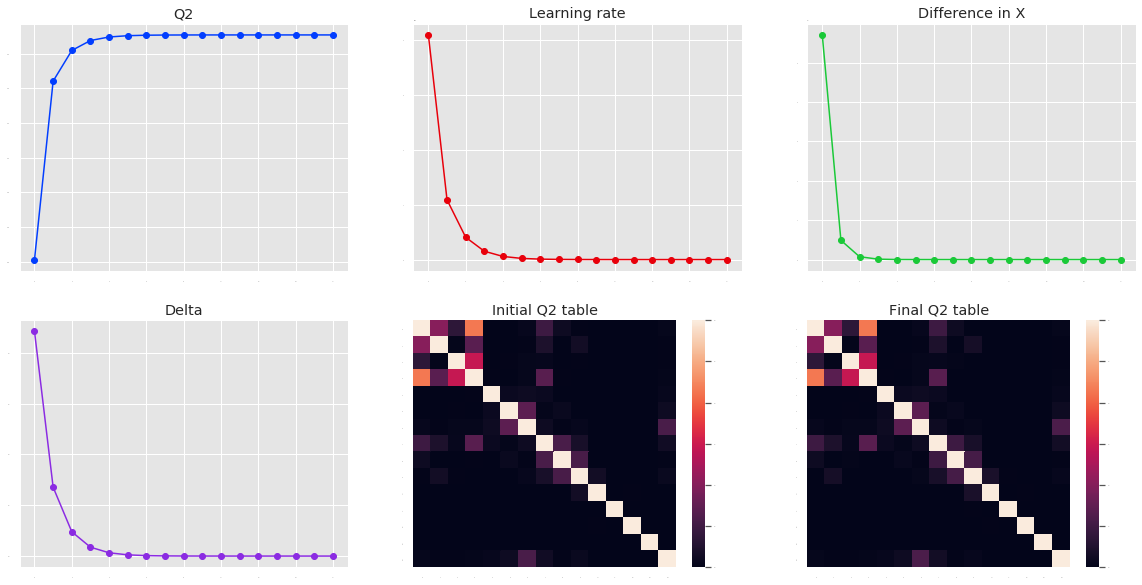

In [62]:
# Apply optimal scaling
X_before_scaling = X.copy()
X,cik = optimal_scaling(X,variable_types,verbose=True,vmax=0.3,fraction_max_step=0.9,max_num_iterations=100)

In [63]:
# saving the pre-processed data and encoding table

np.save(dataset_name+'_X_processed.npy',X)
np.save(dataset_name+'_cik.npy',cik)

FVE PC1 0.12426972634569423 FVE PC2 0.09144839709446648
FVE PC1 in retained dimensions 0.27316365250037566 FVE PC2 in retained dimensions 0.20101740705647528
Explained variance: [0.12426973 0.21571812 0.28596398 0.34664453 0.40286727 0.45492775
 0.50589033 0.55223324 0.59783575 0.64238187 0.68578777 0.72864091
 0.76890698 0.8048463  0.83973664 0.87096411 0.90018619 0.92808775
 0.95096064 0.97299104 0.98990879 1.        ]


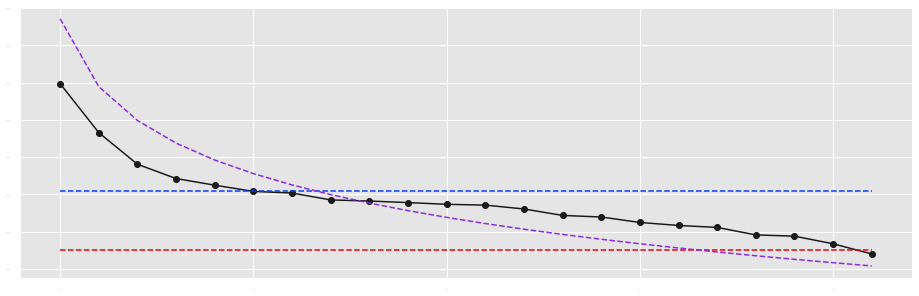

In [252]:
# reducing dimension via PCA
initial_dimension = 6

X = scipy.stats.zscore(X)

pca = PCA(n_components=X.shape[1],svd_solver='full')
Y = pca.fit_transform(X)
s = pca.explained_variance_ratio_
print('FVE PC1',s[0]/np.sum(s),'FVE PC2',s[1]/np.sum(s))
print('FVE PC1 in retained dimensions',s[0]/np.sum(s[0:initial_dimension]),'FVE PC2 in retained dimensions',s[1]/np.sum(s[0:initial_dimension]))
v = pca.components_.T
mean_val = np.mean(X,axis=0)

if 'X_before_scaling' in locals():
    X_before_scaling = scipy.stats.zscore(X_before_scaling)
    Ybs = pca.fit_transform(X_before_scaling)
    sbs = pca.explained_variance_ratio_
    vbs = pca.components_.T
    
fig = plt.figure(figsize=(16,5))
if 'X_before_scaling' in locals():
    plt.plot(sbs,'go-')
plt.plot(s,'ko-')
plt.plot([0,X.shape[1]-1],[s[0]/10,s[0]/10],'r--')
plt.plot([0,X.shape[1]-1],[s[initial_dimension-1],s[initial_dimension-1]],'b--')
plt.plot(brokenstick_distribution(len(s)),'m--')

print('Explained variance:',np.cumsum(s))

X = Y[:,0:initial_dimension]

# this is for applying ELMAP in MATLAB
ElMapFolder = '/mnt/c/MyPrograms/__github/ElMap'
if os.path.exists(ElMapFolder+'/tests/'):
    np.savetxt(ElMapFolder+'/tests/'+'_input.txt', X, delimiter="\t")
    
plt.savefig(dataset_name+'_scree_plot.png', format='png', dpi=300)

In [253]:
# Changing class colors for visualization

if True:
    clrs = []
    for c in color:
        if c==0:
            clrs.append('k')
        if c==1:
            clrs.append('b')
        if c==2:
            clrs.append('r')
    color = clrs

Generating the initial configuration
Creating a chain in the 1st PC with 2 nodes
90% of the points have been used as initial conditions. Resetting.
Constructing tree 1 of 1 / Subset 1 of 1
Performing PCA
Using standard PCA
6 dimensions are being used
100.0 % of the original variance has been retained
The elastic matrix is being used. Edge configuration will be ignored
Computing EPG with  50  nodes on  99343  points and  6  dimensions
Nodes =  2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

1|7||50	4.267	50	49	31	7	0	0	3.5657	3.5532	0.6437	0.645	0.6904	0.011	0.5475	27.3761	0


MSDEnergyPlot not yet implemented
accuracyComplexityPlot not yet implemented
446.3715  seconds elapsed


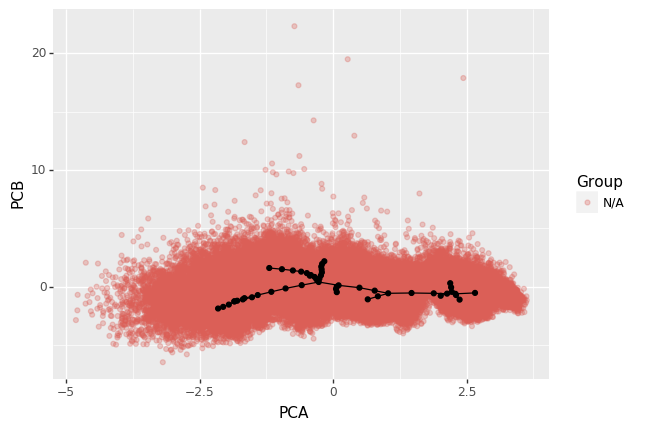

[<ggplot: (8734366250537)>]
Removed 3 vertices and 3 edges
12 labels generated


In [118]:
# Construct and post-process the principal tree

nnodes = 50

tree_elpi = elpigraph.computeElasticPrincipalTree(X,nnodes,drawPCAView=True,alpha=0.01,Mu=0.1,Lambda=0.05,FinalEnergy='Penalized')
tree_elpi = tree_elpi[0]
# some additional pruning of the graph
prune_the_tree(tree_elpi)
# extend the leafs to reach the extreme data points
tree_extended = ExtendLeaves_modified(X, tree_elpi, Mode = "QuantDists", ControlPar = .5, DoSA = False)
# paritioning the data by tree branches
vec_labels_by_branches = partition_data_by_tree_branches(X,tree_extended)
print(len(set(vec_labels_by_branches)),'labels generated')
# paritioning the data by proximity to nodes
nodep = tree_elpi['NodePositions']
partition, dists = elpigraph.src.core.PartitionData(X = X, NodePositions = nodep, MaxBlockSize = 100000000, TrimmingRadius = np.inf,SquaredX = np.sum(X**2,axis=1,keepdims=1))
partition_by_node = np.zeros(len(partition))
for i,p in enumerate(partition):
    partition_by_node[i] = p[0]

In [306]:
# Serialize the results if needed, for repeatitive use
import pickle as pkl
with open(dataset_name+'_dim'+str(X.shape[1])+'_tree_extended.pickle', 'wb') as handle:
    pkl.dump(tree_extended, handle,protocol=pkl.HIGHEST_PROTOCOL)
with open(dataset_name+'_dim'+str(X.shape[1])+'_X.pickle', 'wb') as handle:
    pkl.dump(X, handle,protocol=pkl.HIGHEST_PROTOCOL)
with open(dataset_name+'_dim'+str(X.shape[1])+'_X_original.pickle', 'wb') as handle:
    pkl.dump(X_original, handle,protocol=pkl.HIGHEST_PROTOCOL)


In [19]:
# Loading the data space and the constructed tree
import pickle as pkl
with open(dataset_name+'_dim'+str(X.shape[1])+'_tree_extended.pickle','rb') as handle:
    pkl.load(handle)
with open(dataset_name+'_dim'+str(X.shape[1])+'_X.pickle','rb') as handle:
    pkl.load(handle)
with open(dataset_name+'_dim'+str(X.shape[1])+'_X_original.pickle','rb') as handle:
    pkl.load(handle)


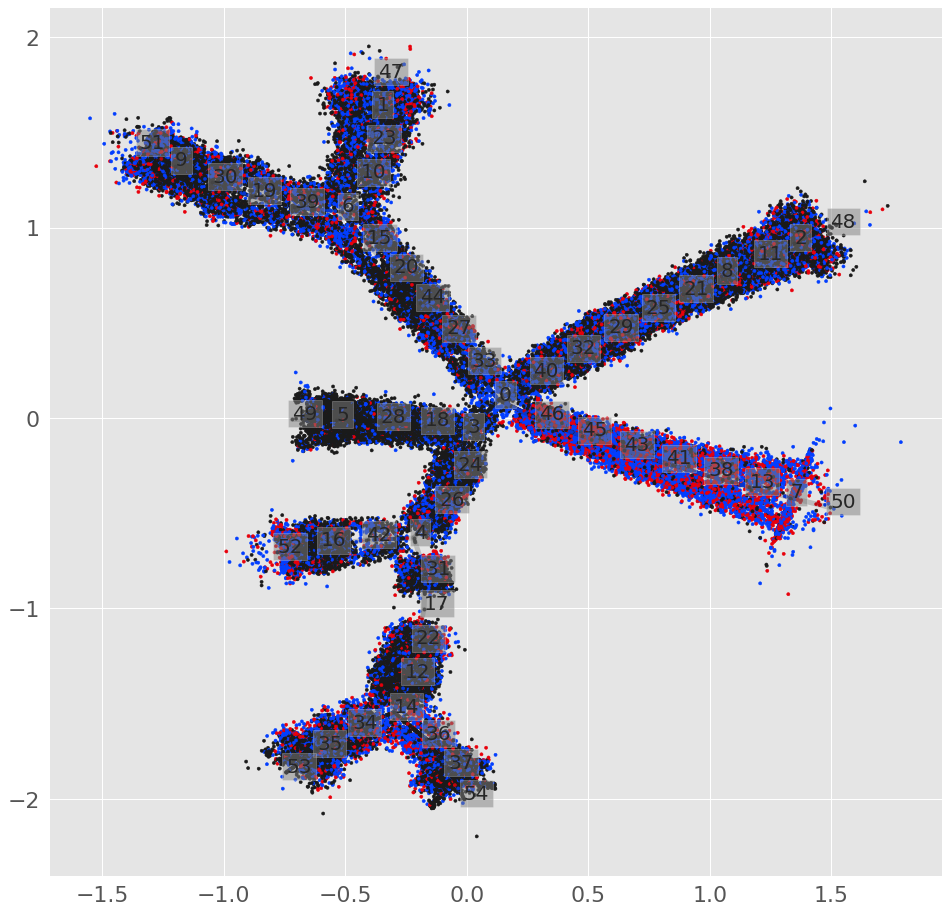

In [307]:
showEdgeNumbers=False
showNodeNumbers=True
showBranchNumbers=False
showPointNumbers=False
Color_by_feature = ''
Feature_Edge_Width = ''
Invert_Edge_Value = False
Min_Edge_Width = 5
Max_Edge_Width = 5
Big_Point_Size = 1000
Small_Point_Size = 100
Normal_Point_Size = 10
Visualize_Edge_Width_AsNodeCoordinates=False
Color_by_partitioning = False
Transparency_Alpha = 0.2
Visualize_Branch_Class_Associations = [] #list_of_branch_class_associations
cmap = 'hot'
highlight_subset = []
Color_by_partitioning=False
partitioning = vec_labels_by_branches
scatter_parameter = 0.05

sns.set(palette='bright',font_scale=2)

#feature = 'LET_IS_0'
feature = ''
fig = plt.figure(figsize=(16, 16))
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,Color_by_feature=feature, Feature_Edge_Width=feature,Invert_Edge_Value=Invert_Edge_Value,Min_Edge_Width=Min_Edge_Width,Max_Edge_Width=Max_Edge_Width,Visualize_Edge_Width_AsNodeCoordinates=Visualize_Edge_Width_AsNodeCoordinates, Color_by_partitioning=Color_by_partitioning, visualize_partition=partitioning, showBranchNumbers=showBranchNumbers,showNodeNumbers=showNodeNumbers,scatter_parameter=scatter_parameter,cmap=cmap,Normal_Point_Size=Normal_Point_Size,highlight_subset=highlight_subset,Big_Point_Size=Big_Point_Size,showPointNumbers=showPointNumbers,Visualize_Branch_Class_Associations=Visualize_Branch_Class_Associations)
plt.savefig(dataset_name+'_principal_tree.png', format='png', dpi=300)

In [310]:
# Associate nodes (vec_labels_by_branches) and classes (color)
# The aim is to identify the root_node (the node most enriched with 'k' class - which means no complications)

Negative_Enrichment = False
Threshold_Deviation = 0.2
Minimal_number_of_points = 20
partitioning = partition_by_node
#partitioning = vec_labels_by_branches
#partitioning = color

list_of_node_class_associations,p,stat = associate_with_categorical_var(partitioning,'CLASS',color,'CATEGORICAL',
                                                            score_threshold=Threshold_Deviation,
                                                            verbose=False,
                                                            Negative_Enrichment=Negative_Enrichment,
                                                            Minimal_number_of_points=Minimal_number_of_points,
                                                                       produce_plot=False)
    
print(list_of_node_class_associations)

k_nodes_scores = [(asst[0],asst[2]) for asst in list_of_node_class_associations if asst[1]=='k']
if len(k_nodes_scores)>0:
    max_score_node = int(k_nodes_scores[np.argmax([t[1] for t in k_nodes_scores])][0])
else:
    max_score_node = 0

root_node = max_score_node

print('Suggested root_node=',root_node)
root_node = 12
print('Selected root_node=',root_node)

[(0.0, 'b', 0.22307763796726998), (7.0, 'r', 0.5705779607529975), (13.0, 'r', 0.5316312463017142), (14.0, 'r', 0.20212566253155967), (38.0, 'b', 0.2113054198418048), (38.0, 'r', 0.49378649019407794), (41.0, 'r', 0.5020650362237972), (43.0, 'b', 0.22685377228810275), (43.0, 'r', 0.46284927647828844), (45.0, 'b', 0.21568518484009647), (45.0, 'r', 0.4611048259661419), (46.0, 'b', 0.20160820224848813), (46.0, 'r', 0.42134174737297564)]
Suggested root_node= 0
Selected root_node= 12


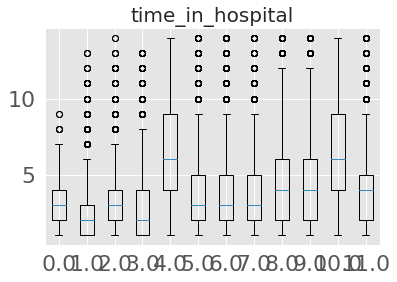

time_in_hospital CONTINUOUS [(4.0, 'CONTINUOUS', 1.3140335947530184), (8.0, 'CONTINUOUS', 0.5291792177387274), (9.0, 'CONTINUOUS', 0.5649905751353776), (10.0, 'CONTINUOUS', 1.358997829772421)] p-value= 0.0


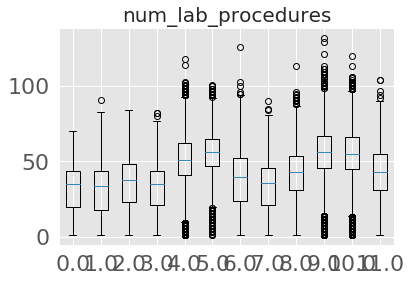

num_lab_procedures CONTINUOUS [(4.0, 'CONTINUOUS', 0.9508259153287646), (5.0, 'CONTINUOUS', 1.1732721899279808), (9.0, 'CONTINUOUS', 1.1913762322809438), (10.0, 'CONTINUOUS', 1.1426424749574886)] p-value= 0.0


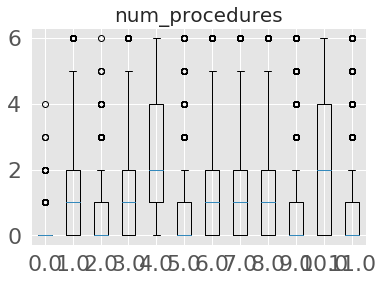

num_procedures CONTINUOUS [(1.0, 'CONTINUOUS', 0.5863563559742194), (4.0, 'CONTINUOUS', 1.3138423561036423), (8.0, 'CONTINUOUS', 0.5701174218823315), (10.0, 'CONTINUOUS', 1.1706908135326337)] p-value= 0.0


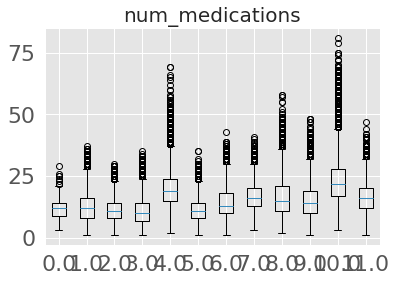

num_medications CONTINUOUS [(4.0, 'CONTINUOUS', 1.0169432639893095), (7.0, 'CONTINUOUS', 0.5661740023865982), (8.0, 'CONTINUOUS', 0.5814408416784658), (10.0, 'CONTINUOUS', 1.456776444882459), (11.0, 'CONTINUOUS', 0.5581424223170127)] p-value= 0.0


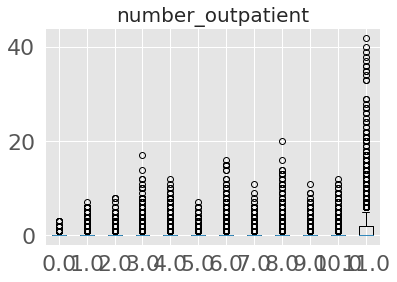

number_outpatient CONTINUOUS [(11.0, 'CONTINUOUS', 0.9303336509652183)] p-value= 0.0


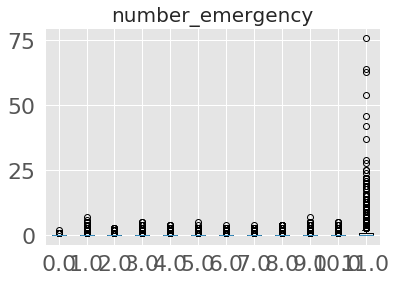

number_emergency CONTINUOUS [(11.0, 'CONTINUOUS', 1.0821879910949337)] p-value= 0.0


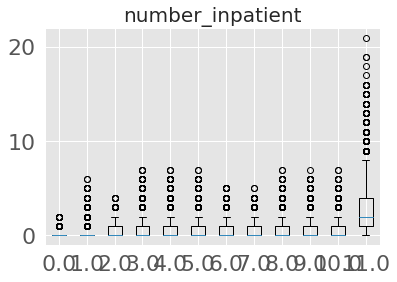

number_inpatient CONTINUOUS [(11.0, 'CONTINUOUS', 1.8722321803538933)] p-value= 0.0


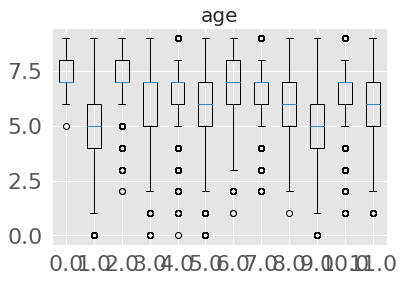

age ORDINAL [(0.0, 'CONTINUOUS', 0.8074708377102693)] p-value= 0.0


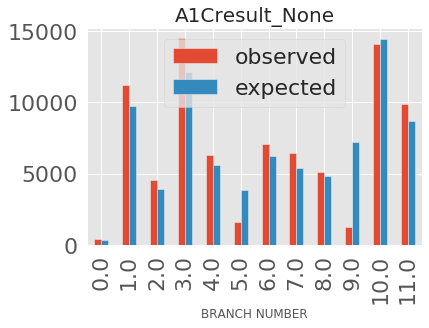

A1Cresult_None BINARY [(5.0, 0.0, 0.5916970996962457), (9.0, 0.0, 0.6684806503219783)] p-value= 0.0


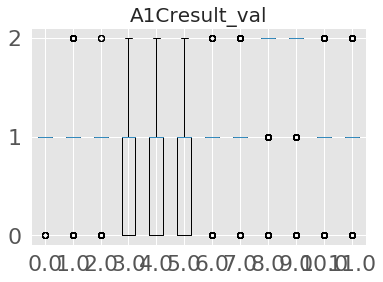

A1Cresult_val ORDINAL [(8.0, 'CONTINUOUS', 1.575042179142425), (9.0, 'CONTINUOUS', 1.3555763093133246)] p-value= 0.0


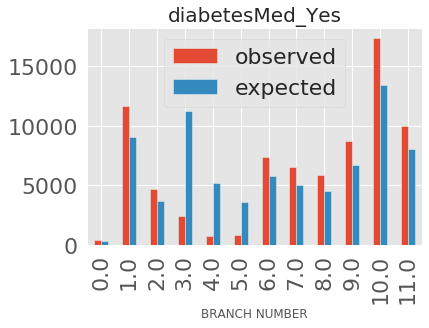

diabetesMed_Yes BINARY [(3.0, 0.0, 0.5712447544973417), (4.0, 0.0, 0.5923518871085293), (5.0, 0.0, 0.562900670535896)] p-value= 0.0


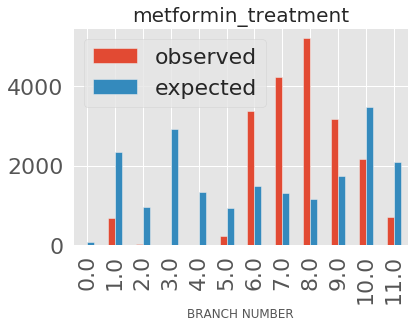

metformin_treatment BINARY [(7.0, 1.0, 0.5294207669732102), (8.0, 1.0, 0.6333951514786086)] p-value= 0.0


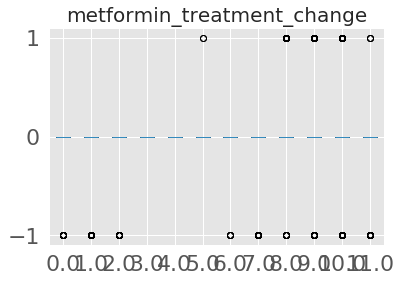

metformin_treatment_change ORDINAL [(8.0, 'CONTINUOUS', 1.282425539652123)] p-value= 0.0


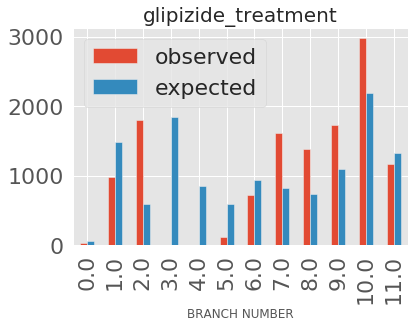

glipizide_treatment BINARY [(2.0, 1.0, 0.5006618582270377)] p-value= 0.0


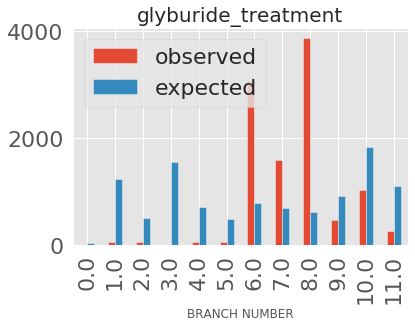

glyburide_treatment BINARY [(6.0, 1.0, 0.588670012961559), (8.0, 1.0, 0.7240418608020747)] p-value= 0.0


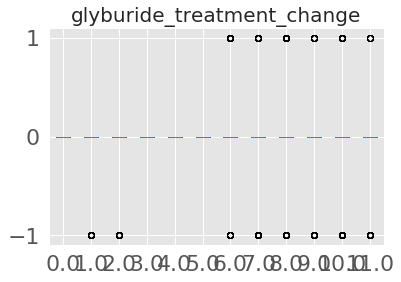

glyburide_treatment_change ORDINAL [(8.0, 'CONTINUOUS', 0.881692394047945)] p-value= 0.0


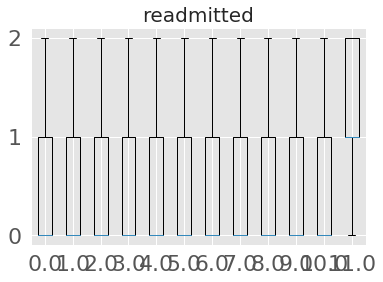

readmitted ORDINAL [(11.0, 'CONTINUOUS', 1.1902205500781835)] p-value= 0.0


In [311]:
# Associate branches (vec_labels_by_branches) and variables (chi-square : binary, ordinal and categorical
# and ANOVA for continuous)

reload(clintraj_util)
from clintraj_util import associate_with_categorical_var


Negative_Enrichment = False
Threshold_Deviation = 0.5
Threshold_Parameter = 0.5
Minimal_number_of_points = 10
pvalue_threshold_parameter = 0.01
produce_plots = True

all_branch_var_associations = {}

for k,var in enumerate(variable_names):
    var_type = variable_types[k]
    vals = X_original[:,k]
    list_of_branch_var_associations=[]
    if var_type=='BINARY' or var_type=='CATEGORICAL':
        list_of_branch_var_associations,p,stat = associate_with_categorical_var(vec_labels_by_branches,var,vals,var_type,
                                                            score_threshold=Threshold_Deviation,
                                                            verbose=False,
                                                            Negative_Enrichment=Negative_Enrichment,
                                                            Minimal_number_of_points=Minimal_number_of_points,
                                                            pvalue_threshold_parameter=pvalue_threshold_parameter,
                                                            produce_plot=produce_plots)
    if var_type=='ORDINAL' or var_type=='CONTINUOUS':
        list_of_branch_var_associations,p,stat = associate_with_categorical_var(vec_labels_by_branches,var,vals,var_type,
                                                            score_threshold=Threshold_Parameter,
                                                            verbose=False,
                                                            Negative_Enrichment=Negative_Enrichment,
                                                            Minimal_number_of_points=Minimal_number_of_points,
                                                            pvalue_threshold_parameter=pvalue_threshold_parameter,
                                                            produce_plot=produce_plots)
    if len(list_of_branch_var_associations)>0:
        print(var,var_type,list_of_branch_var_associations,'p-value=',p)
        all_branch_var_associations[var] = list_of_branch_var_associations

['A1Cresult_val', 'metformin_treatment', 'glyburide_treatment', 'metformin_treatment_change', 'glyburide_treatment_change', 'num_medications', 'time_in_hospital', 'num_procedures', 'diabetesMed_Yes', 'num_lab_procedures', 'A1Cresult_None', 'readmitted', 'number_inpatient', 'number_outpatient', 'number_emergency', 'age', 'glipizide_treatment']



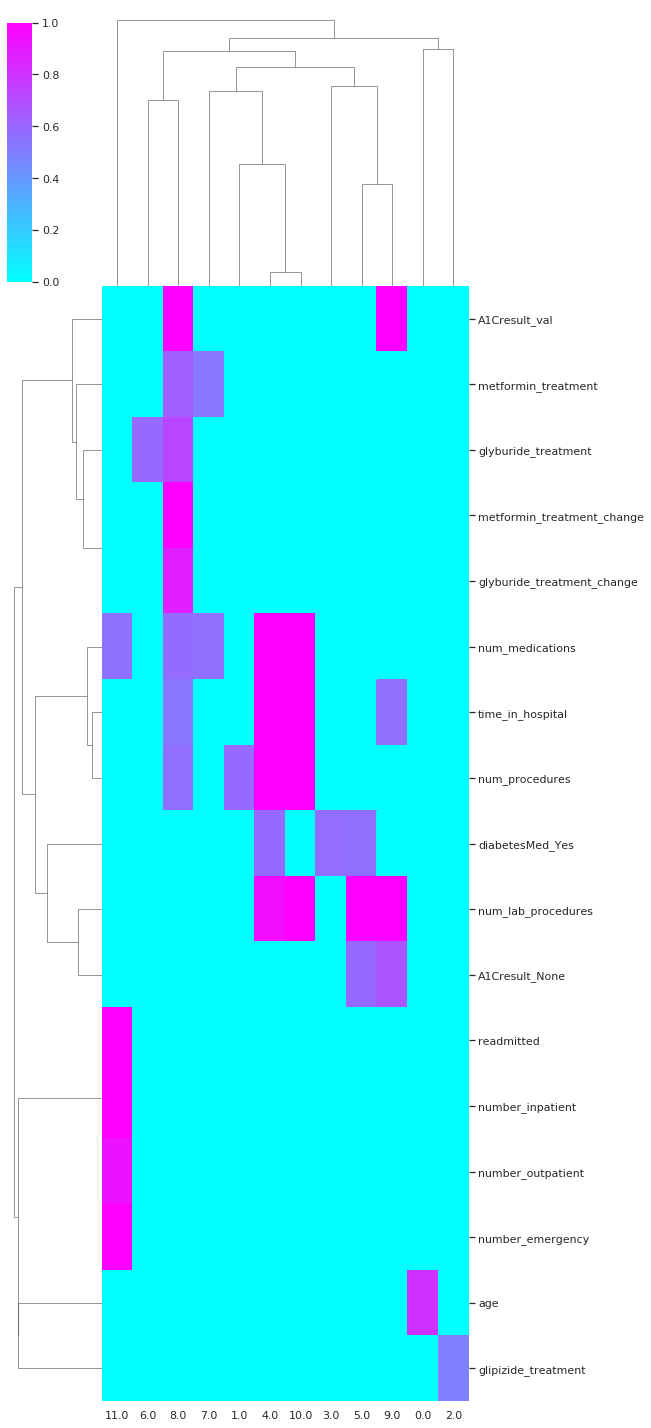

In [312]:
# Visualize associations between variables and tree branches

matrix_of_scores,keys,objects = get_matrix_of_association_scores(all_branch_var_associations)

sns.set(color_codes=True)
#g = sns.clustermap(matrix_of_scores,metric="correlation",figsize=(7, 20))
g = sns.clustermap(matrix_of_scores,metric="correlation",figsize=(7, 20),vmax=1,cmap='cool')
objects_reordered = [objects[ind] for ind in g.dendrogram_col.reordered_ind]
keys_reordered = [keys[ind] for ind in g.dendrogram_row.reordered_ind]
g.ax_heatmap.set_xticklabels(objects_reordered)
g.ax_heatmap.set_yticklabels(keys_reordered)
print(keys_reordered)
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
plt.savefig(dataset_name+'_assoc_branches.png', format='png', dpi=300)
print()

In [313]:
reload(clintraj_eltree)
from clintraj_eltree import convert_elpigraph_to_igraph

# Quantify pseudo-time

all_trajectories = extract_trajectories(tree_extended,root_node)
print(len(all_trajectories),' trajectories found.')
ProjStruct = project_on_tree(X,tree_extended)
PseudoTimeTraj = quantify_pseudotime(all_trajectories,ProjStruct)
# add information about bifurcation points
g = convert_elpigraph_to_igraph(tree_extended)
degs = g.degree()
for pss in PseudoTimeTraj:
    traj = pss['Trajectory']
    branching_marks = []
    for i,n in enumerate(traj):
        if degs[n]>2 and i>0:
            branching_marks.append(i)
    pss['BranchingPoints'] = branching_marks
    #print(n,branching_marks)

8  trajectories found.


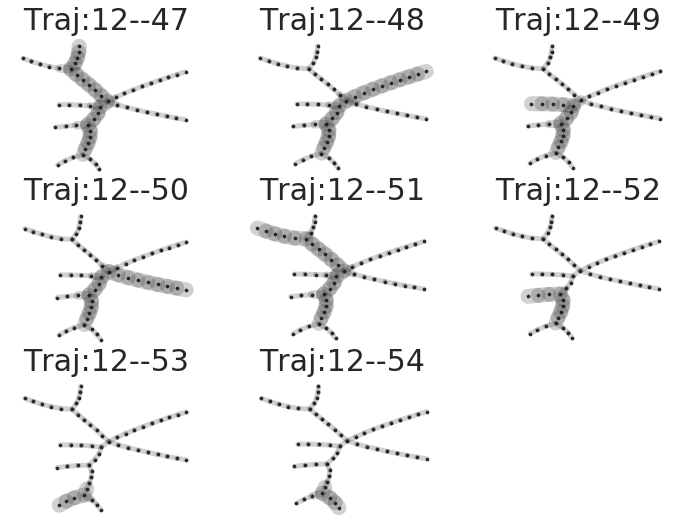

In [314]:
# Visualize all trajectories
reload(clintraj_eltree)
from clintraj_eltree import visualize_eltree_with_data,pseudo_time_trajectory,extract_trajectories,quantify_pseudotime

n_subplots_x, n_subplots_y = 4, 3
plt.style.use('ggplot')
fig = plt.figure(figsize=(12, 12))

for i,pstt in enumerate(PseudoTimeTraj):
    points = list(pstt['Points'])
    X_fake = np.zeros((X.shape[0],1))
    X_fake[points,0] = 1.0
    TrajName = 'Traj:'+str(pstt['Trajectory'][0])+'--'+str(pstt['Trajectory'][-1])
    ax = fig.add_subplot(n_subplots_x,n_subplots_y,i+1)
    plt.title(TrajName,fontsize=30)
    visualize_eltree_with_data(tree_extended,X,X_fake,v,mean_val,color,['Traj'],
                          Min_Edge_Width=5,Max_Edge_Width=15,Normal_Point_Size = 0,
                          Color_by_feature='', Feature_Edge_Width='Traj',
                          Visualize_Edge_Width_AsNodeCoordinates=False)
    plt.axis('off')
    #plt.savefig(dataset_name+'_trajectories.png', format='png', dpi=300)



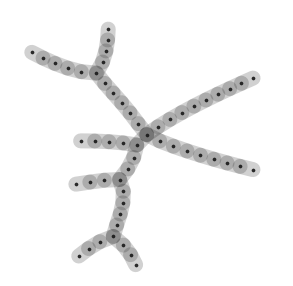

In [384]:
# produce principal tree scaffold image

fig = plt.figure(figsize=(5, 5))
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,['Traj'],
                          Min_Edge_Width=15,Max_Edge_Width=15,Normal_Point_Size = 0,
                          Color_by_feature='', Feature_Edge_Width='Traj',
                          Visualize_Edge_Width_AsNodeCoordinates=False)
plt.axis('off')
plt.savefig(dataset_name+'_tree_structure.png', format='png', dpi=600)


time_in_hospital CONTINUOUS


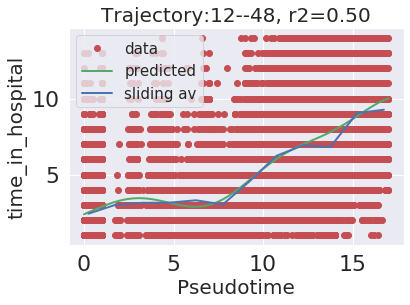

1 ('Trajectory:12--48', 'time_in_hospital', 0.49689023805383437)


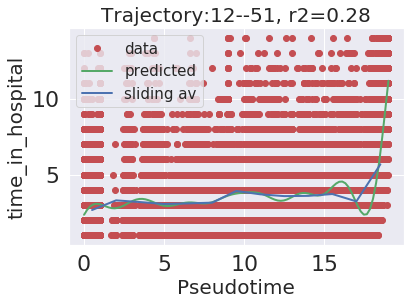

4 ('Trajectory:12--51', 'time_in_hospital', 0.27739783203643686)


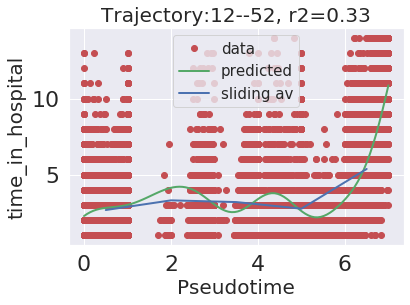

5 ('Trajectory:12--52', 'time_in_hospital', 0.32609834808167326)


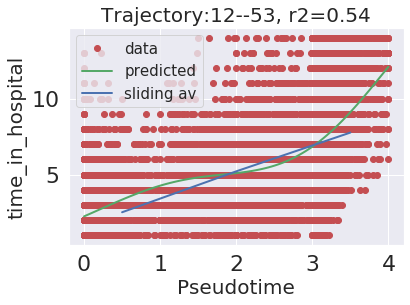

6 ('Trajectory:12--53', 'time_in_hospital', 0.5417805584847496)
[('Trajectory:12--48', 'time_in_hospital', 0.49689023805383437), ('Trajectory:12--51', 'time_in_hospital', 0.27739783203643686), ('Trajectory:12--52', 'time_in_hospital', 0.32609834808167326), ('Trajectory:12--53', 'time_in_hospital', 0.5417805584847496)]
num_lab_procedures CONTINUOUS


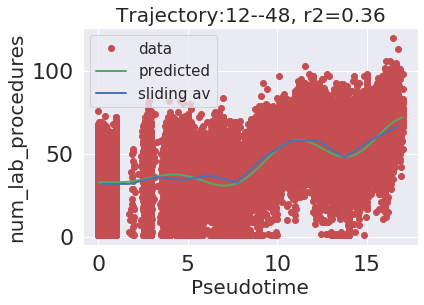

1 ('Trajectory:12--48', 'num_lab_procedures', 0.35634823500390833)


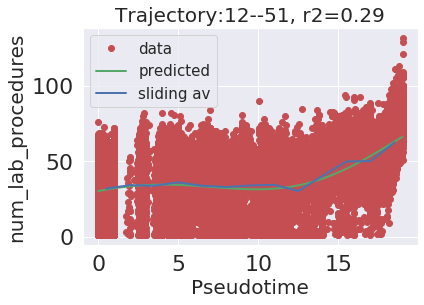

4 ('Trajectory:12--51', 'num_lab_procedures', 0.2924249540292547)


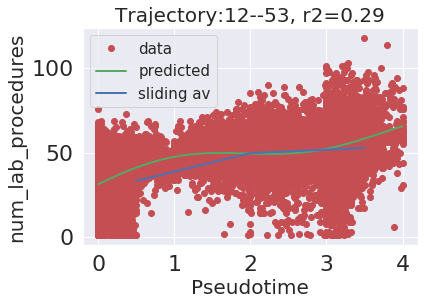

6 ('Trajectory:12--53', 'num_lab_procedures', 0.2911952649315749)


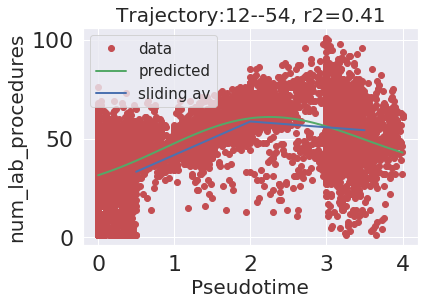

7 ('Trajectory:12--54', 'num_lab_procedures', 0.4092927011695018)
[('Trajectory:12--48', 'num_lab_procedures', 0.35634823500390833), ('Trajectory:12--51', 'num_lab_procedures', 0.2924249540292547), ('Trajectory:12--53', 'num_lab_procedures', 0.2911952649315749), ('Trajectory:12--54', 'num_lab_procedures', 0.4092927011695018)]
num_procedures CONTINUOUS


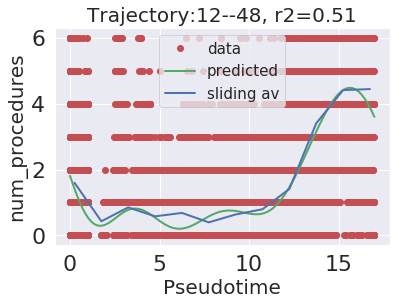

1 ('Trajectory:12--48', 'num_procedures', 0.5135284401007344)


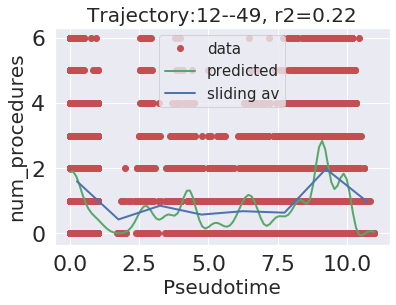

2 ('Trajectory:12--49', 'num_procedures', 0.21745516275675292)


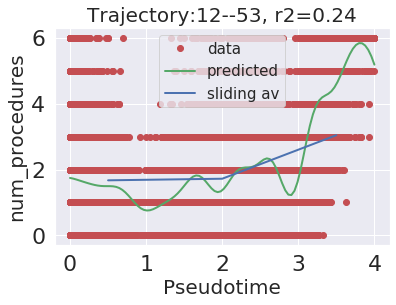

6 ('Trajectory:12--53', 'num_procedures', 0.2409544007123452)
[('Trajectory:12--48', 'num_procedures', 0.5135284401007344), ('Trajectory:12--49', 'num_procedures', 0.21745516275675292), ('Trajectory:12--53', 'num_procedures', 0.2409544007123452)]
num_medications CONTINUOUS


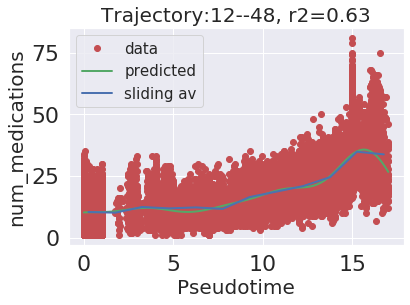

1 ('Trajectory:12--48', 'num_medications', 0.6333865128898319)


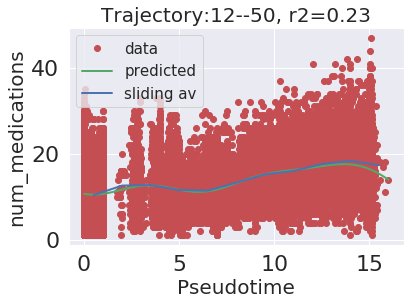

3 ('Trajectory:12--50', 'num_medications', 0.22624438764584454)


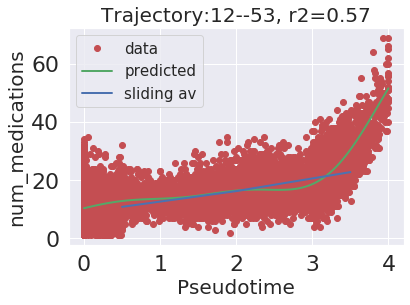

6 ('Trajectory:12--53', 'num_medications', 0.5660923869770709)
[('Trajectory:12--48', 'num_medications', 0.6333865128898319), ('Trajectory:12--50', 'num_medications', 0.22624438764584454), ('Trajectory:12--53', 'num_medications', 0.5660923869770709)]
number_outpatient CONTINUOUS
number_emergency CONTINUOUS


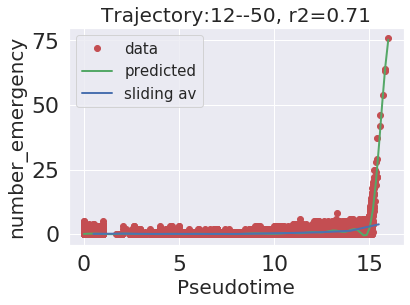

3 ('Trajectory:12--50', 'number_emergency', 0.708753400493163)
[('Trajectory:12--50', 'number_emergency', 0.708753400493163)]
number_inpatient CONTINUOUS


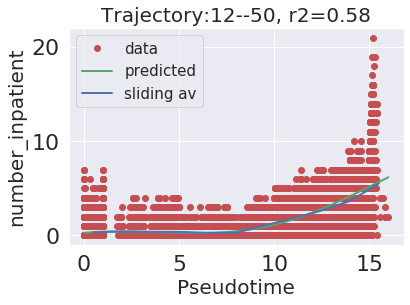

3 ('Trajectory:12--50', 'number_inpatient', 0.5794304864316133)
[('Trajectory:12--50', 'number_inpatient', 0.5794304864316133)]
number_diagnoses CONTINUOUS


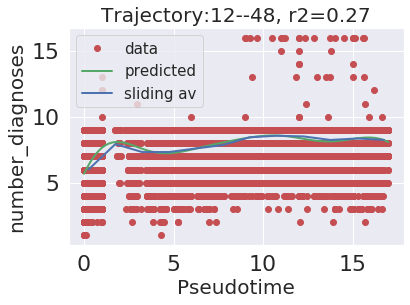

1 ('Trajectory:12--48', 'number_diagnoses', 0.26768126679877413)


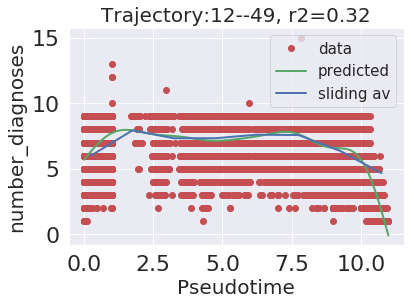

2 ('Trajectory:12--49', 'number_diagnoses', 0.3163764753781829)


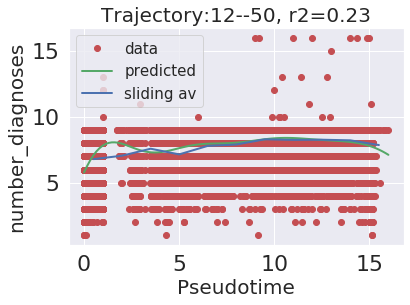

3 ('Trajectory:12--50', 'number_diagnoses', 0.22671889956001834)


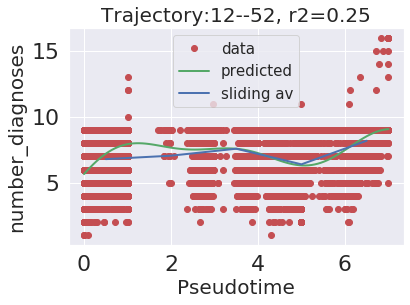

5 ('Trajectory:12--52', 'number_diagnoses', 0.2489474128560749)


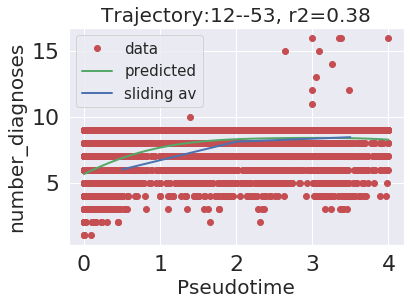

6 ('Trajectory:12--53', 'number_diagnoses', 0.3801575915335712)


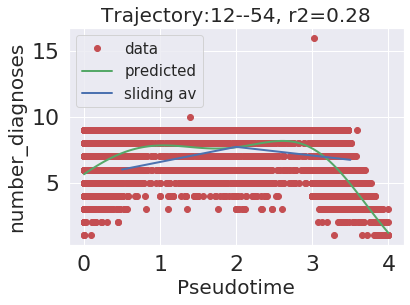

7 ('Trajectory:12--54', 'number_diagnoses', 0.278179873324102)
[('Trajectory:12--48', 'number_diagnoses', 0.26768126679877413), ('Trajectory:12--49', 'number_diagnoses', 0.3163764753781829), ('Trajectory:12--50', 'number_diagnoses', 0.22671889956001834), ('Trajectory:12--52', 'number_diagnoses', 0.2489474128560749), ('Trajectory:12--53', 'number_diagnoses', 0.3801575915335712), ('Trajectory:12--54', 'number_diagnoses', 0.278179873324102)]
age ORDINAL


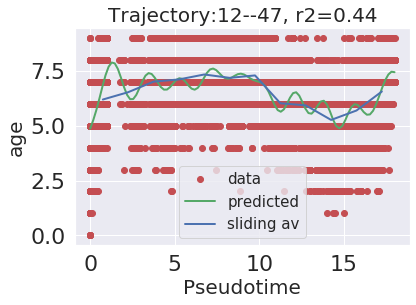

0 ('Trajectory:12--47', 'age', 0.43657190596983864)


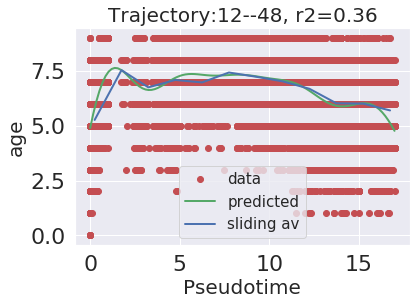

1 ('Trajectory:12--48', 'age', 0.3554541942665833)


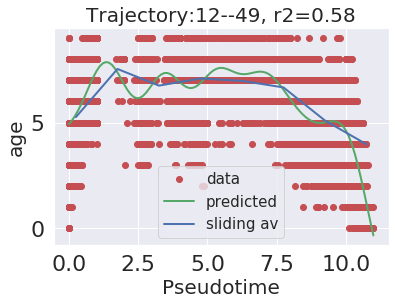

2 ('Trajectory:12--49', 'age', 0.5825363728555475)


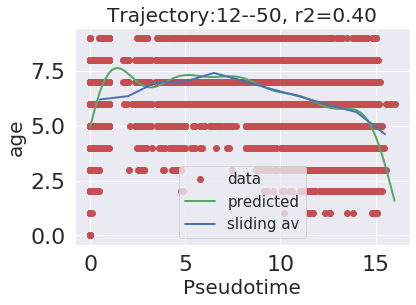

3 ('Trajectory:12--50', 'age', 0.4014094225805642)


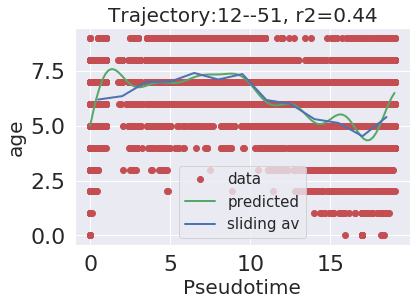

4 ('Trajectory:12--51', 'age', 0.43948131694688364)


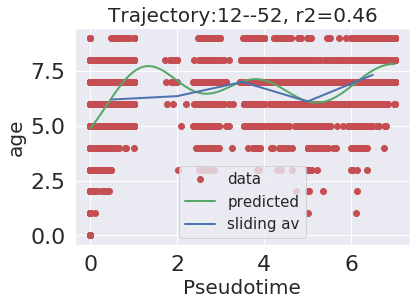

5 ('Trajectory:12--52', 'age', 0.46411814798380757)


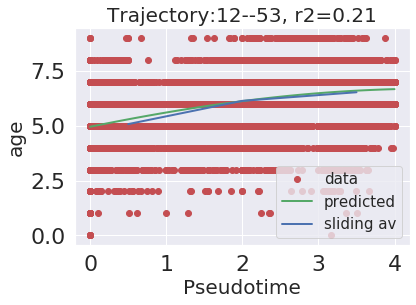

6 ('Trajectory:12--53', 'age', 0.2073291639127054)


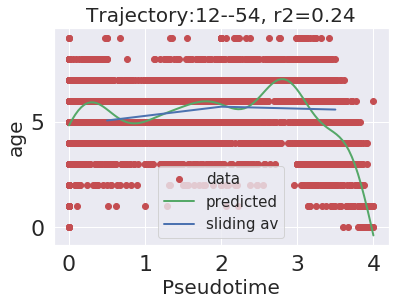

7 ('Trajectory:12--54', 'age', 0.2359564825005288)
[('Trajectory:12--47', 'age', 0.43657190596983864), ('Trajectory:12--48', 'age', 0.3554541942665833), ('Trajectory:12--49', 'age', 0.5825363728555475), ('Trajectory:12--50', 'age', 0.4014094225805642), ('Trajectory:12--51', 'age', 0.43948131694688364), ('Trajectory:12--52', 'age', 0.46411814798380757), ('Trajectory:12--53', 'age', 0.2073291639127054), ('Trajectory:12--54', 'age', 0.2359564825005288)]
A1Cresult_None BINARY


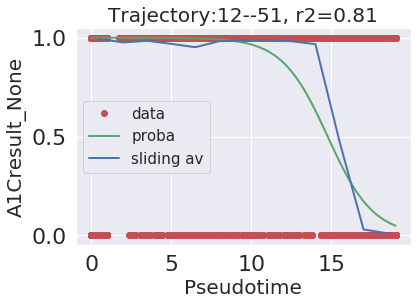

4 ('Trajectory:12--51', 'A1Cresult_None', 0.8057545948816406)


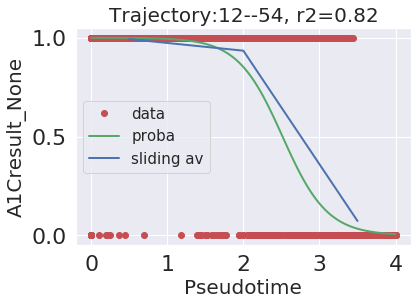

7 ('Trajectory:12--54', 'A1Cresult_None', 0.8193246772654252)
[('Trajectory:12--51', 'A1Cresult_None', 0.8057545948816406), ('Trajectory:12--54', 'A1Cresult_None', 0.8193246772654252)]
A1Cresult_val ORDINAL


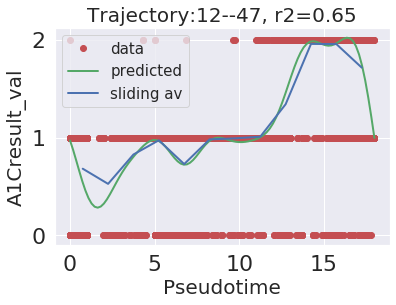

0 ('Trajectory:12--47', 'A1Cresult_val', 0.6520395141462119)


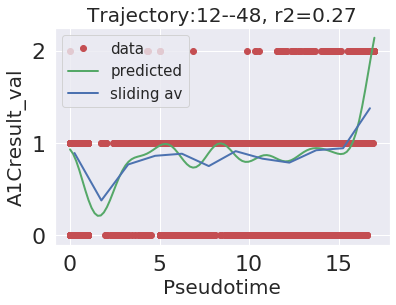

1 ('Trajectory:12--48', 'A1Cresult_val', 0.26636436613759484)


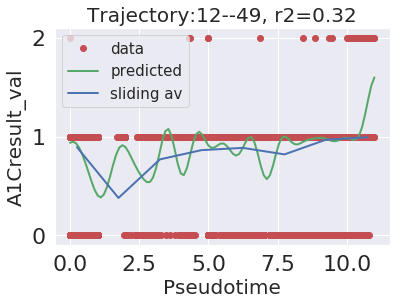

2 ('Trajectory:12--49', 'A1Cresult_val', 0.32242411470127774)


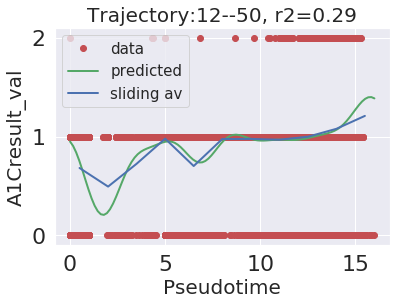

3 ('Trajectory:12--50', 'A1Cresult_val', 0.2933334179613959)


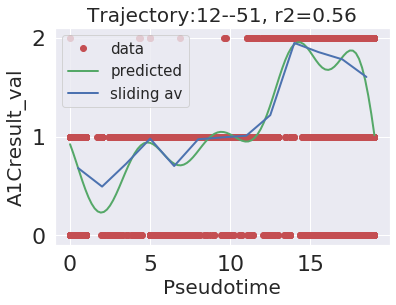

4 ('Trajectory:12--51', 'A1Cresult_val', 0.5609256876546765)


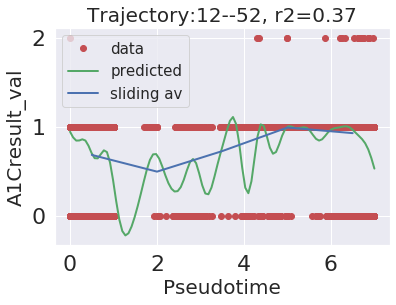

5 ('Trajectory:12--52', 'A1Cresult_val', 0.36613354142413557)


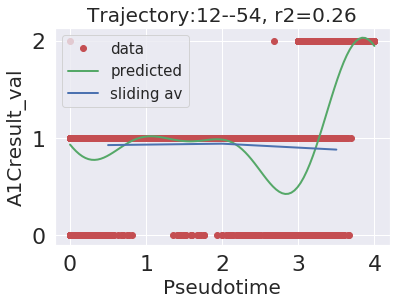

7 ('Trajectory:12--54', 'A1Cresult_val', 0.259507407500273)
[('Trajectory:12--47', 'A1Cresult_val', 0.6520395141462119), ('Trajectory:12--48', 'A1Cresult_val', 0.26636436613759484), ('Trajectory:12--49', 'A1Cresult_val', 0.32242411470127774), ('Trajectory:12--50', 'A1Cresult_val', 0.2933334179613959), ('Trajectory:12--51', 'A1Cresult_val', 0.5609256876546765), ('Trajectory:12--52', 'A1Cresult_val', 0.36613354142413557), ('Trajectory:12--54', 'A1Cresult_val', 0.259507407500273)]
change_Ch BINARY


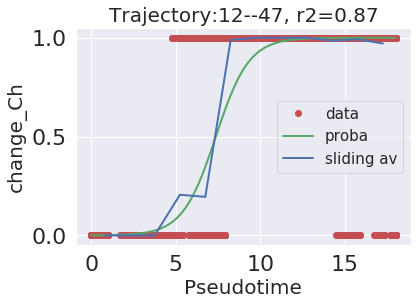

0 ('Trajectory:12--47', 'change_Ch', 0.874885319060412)


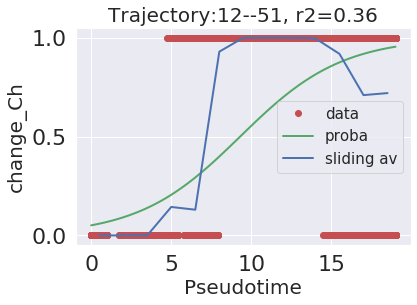

4 ('Trajectory:12--51', 'change_Ch', 0.35835692635943106)
[('Trajectory:12--47', 'change_Ch', 0.874885319060412), ('Trajectory:12--51', 'change_Ch', 0.35835692635943106)]
diabetesMed_Yes BINARY


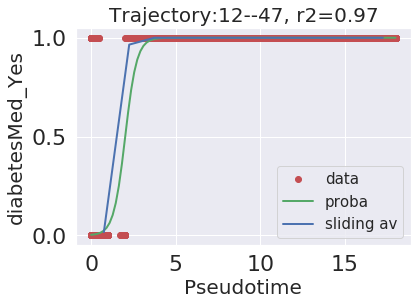

0 ('Trajectory:12--47', 'diabetesMed_Yes', 0.973416027726741)


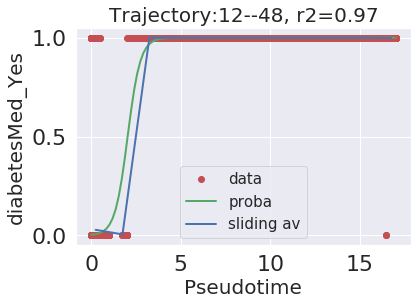

1 ('Trajectory:12--48', 'diabetesMed_Yes', 0.9747886750266473)


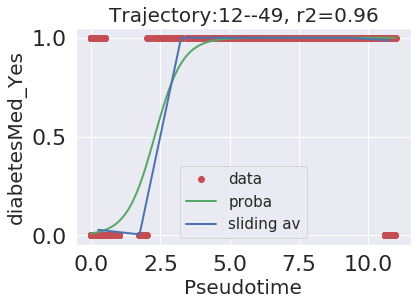

2 ('Trajectory:12--49', 'diabetesMed_Yes', 0.9645413704092155)


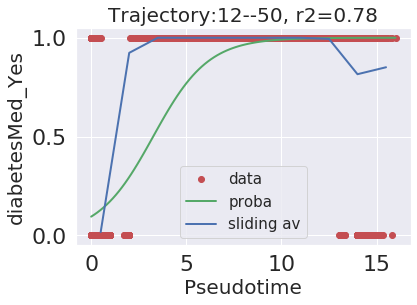

3 ('Trajectory:12--50', 'diabetesMed_Yes', 0.7810736507837698)


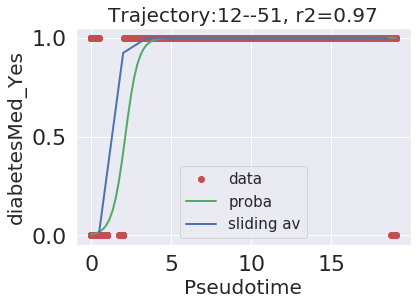

4 ('Trajectory:12--51', 'diabetesMed_Yes', 0.9729676550478292)


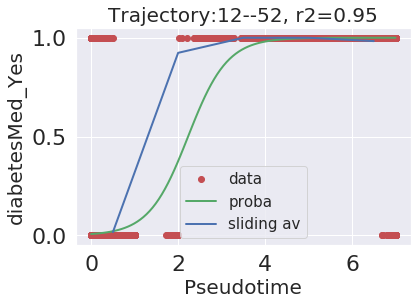

5 ('Trajectory:12--52', 'diabetesMed_Yes', 0.9512379233954924)
[('Trajectory:12--47', 'diabetesMed_Yes', 0.973416027726741), ('Trajectory:12--48', 'diabetesMed_Yes', 0.9747886750266473), ('Trajectory:12--49', 'diabetesMed_Yes', 0.9645413704092155), ('Trajectory:12--50', 'diabetesMed_Yes', 0.7810736507837698), ('Trajectory:12--51', 'diabetesMed_Yes', 0.9729676550478292), ('Trajectory:12--52', 'diabetesMed_Yes', 0.9512379233954924)]
metformin_treatment BINARY


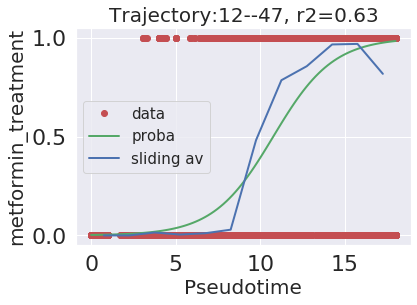

0 ('Trajectory:12--47', 'metformin_treatment', 0.6267685962473901)
[('Trajectory:12--47', 'metformin_treatment', 0.6267685962473901)]
metformin_treatment_change ORDINAL
glipizide_treatment BINARY
glipizide_treatment_change ORDINAL
glyburide_treatment BINARY


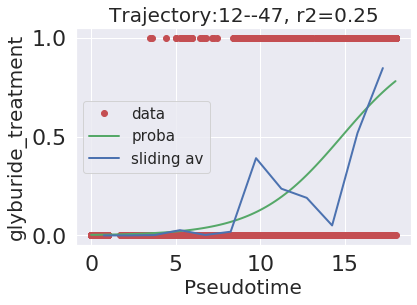

0 ('Trajectory:12--47', 'glyburide_treatment', 0.2462471301118263)
[('Trajectory:12--47', 'glyburide_treatment', 0.2462471301118263)]
glyburide_treatment_change ORDINAL
insulin_treatment BINARY


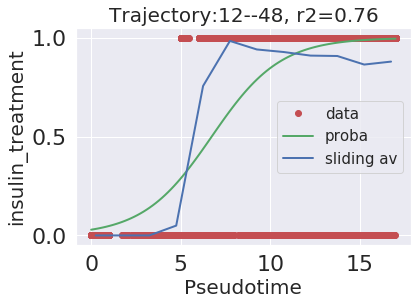

1 ('Trajectory:12--48', 'insulin_treatment', 0.7649433090500287)


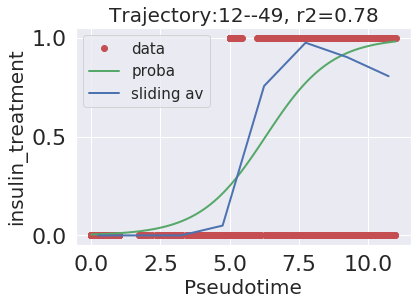

2 ('Trajectory:12--49', 'insulin_treatment', 0.7792036013020385)


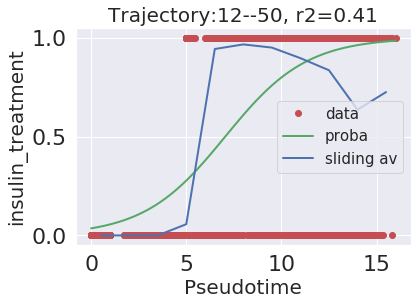

3 ('Trajectory:12--50', 'insulin_treatment', 0.4089916712448829)


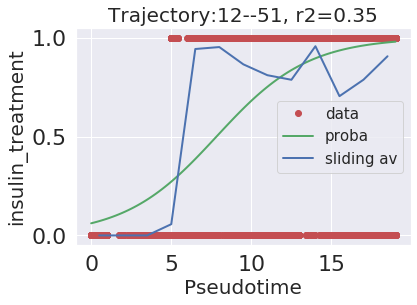

4 ('Trajectory:12--51', 'insulin_treatment', 0.3502677489964121)


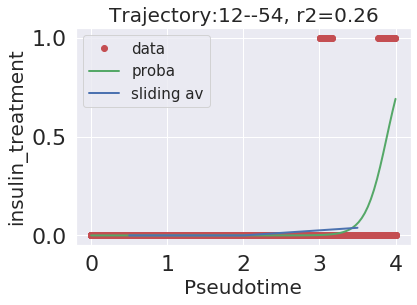

7 ('Trajectory:12--54', 'insulin_treatment', 0.2580716566604019)
[('Trajectory:12--48', 'insulin_treatment', 0.7649433090500287), ('Trajectory:12--49', 'insulin_treatment', 0.7792036013020385), ('Trajectory:12--50', 'insulin_treatment', 0.4089916712448829), ('Trajectory:12--51', 'insulin_treatment', 0.3502677489964121), ('Trajectory:12--54', 'insulin_treatment', 0.2580716566604019)]
insulin_treatment_change ORDINAL
readmitted ORDINAL


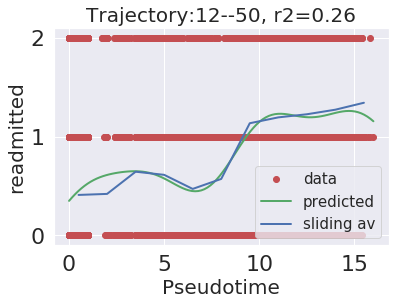

3 ('Trajectory:12--50', 'readmitted', 0.2557253653898949)
[('Trajectory:12--50', 'readmitted', 0.2557253653898949)]


In [406]:
# associate trajectories with variables by regression

reload(clintraj_eltree)
from clintraj_eltree import regression_of_variable_with_trajectories


R2_Threshold = 0.2
R2_Threshold_For_Readmission = 0.1
producePlot = True
all_trajectory_variable_associations = {}
readmission_variables = ['readmitted']

for k,var in enumerate(variable_names):
    print(var,variable_types[variable_names.index(var)])
    if var in readmission_variables:
        r2th = R2_Threshold_For_Readmission
    else:
        r2th = R2_Threshold
    List_of_Associations = regression_of_variable_with_trajectories(PseudoTimeTraj,var,variable_names,
                                                                    variable_types,X_original,R2_Threshold=r2th,
                                                                    producePlot=producePlot,
                                                                    Continuous_Regression_Type='gpr',
                                                                    verbose=True,max_sample=2000,alpha_factor=1)
    if len(List_of_Associations)>0:
        print(List_of_Associations)
        all_trajectory_variable_associations[var]=List_of_Associations

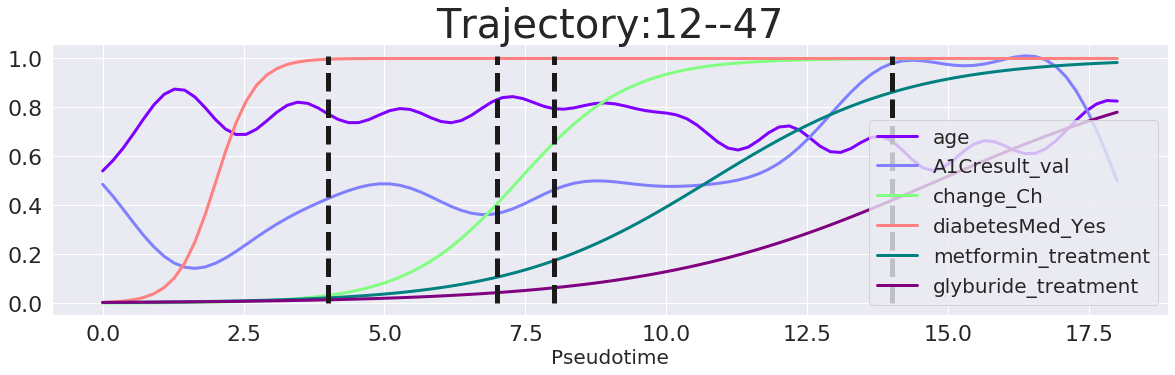

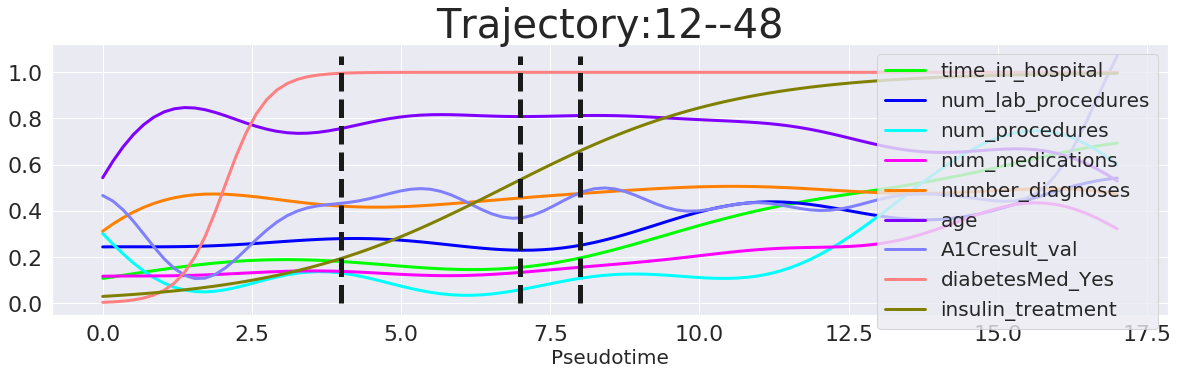

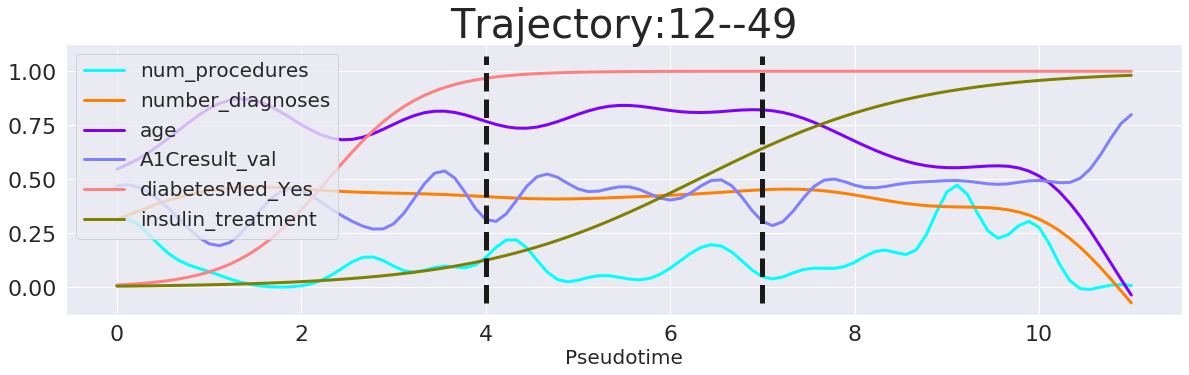

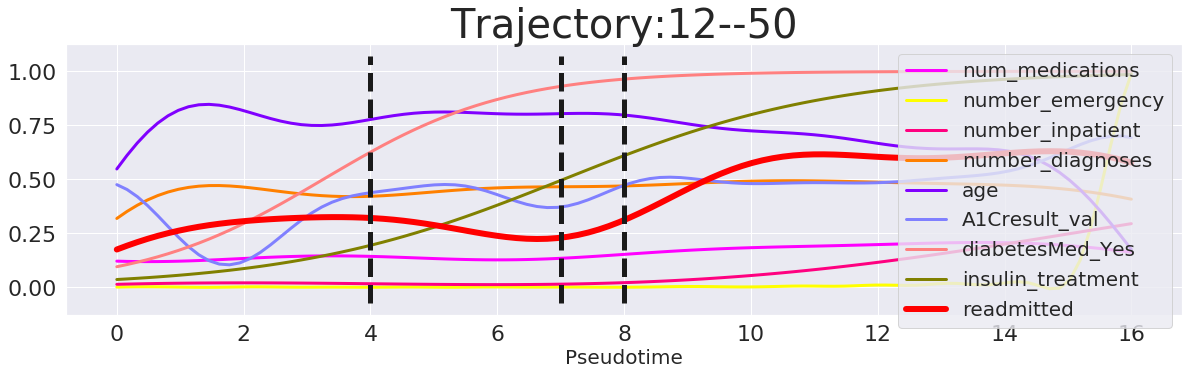

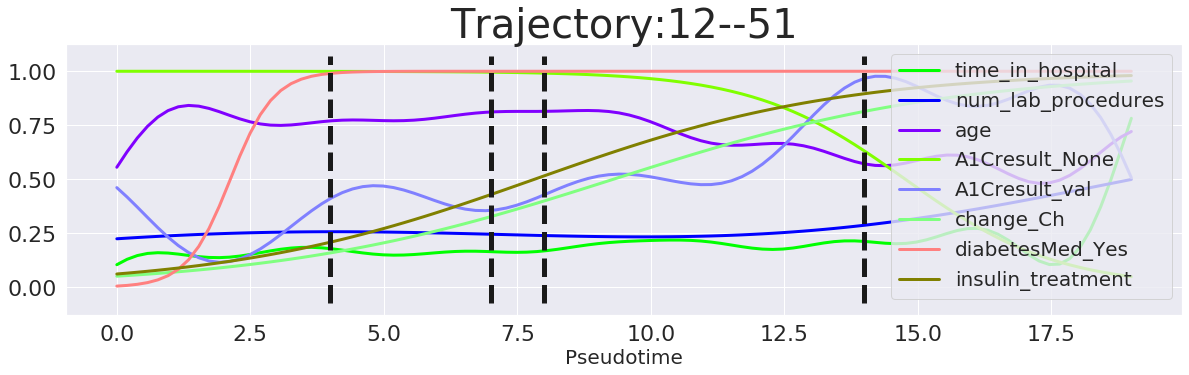

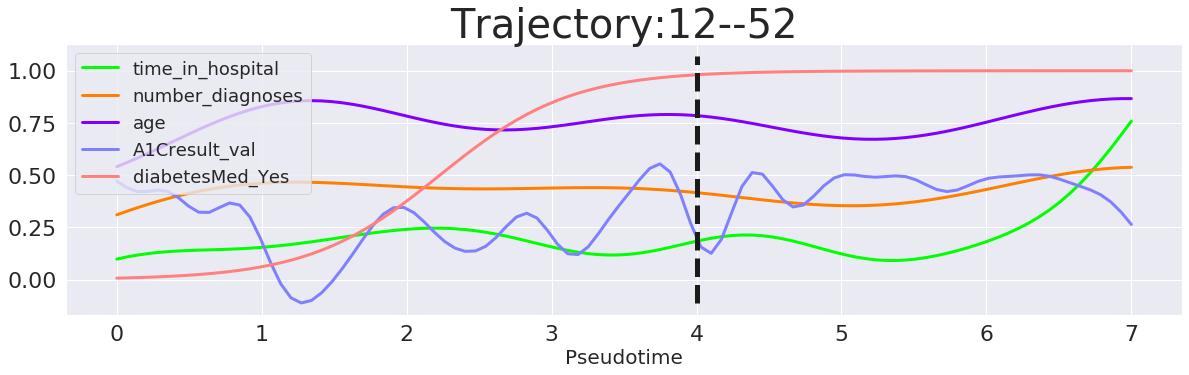

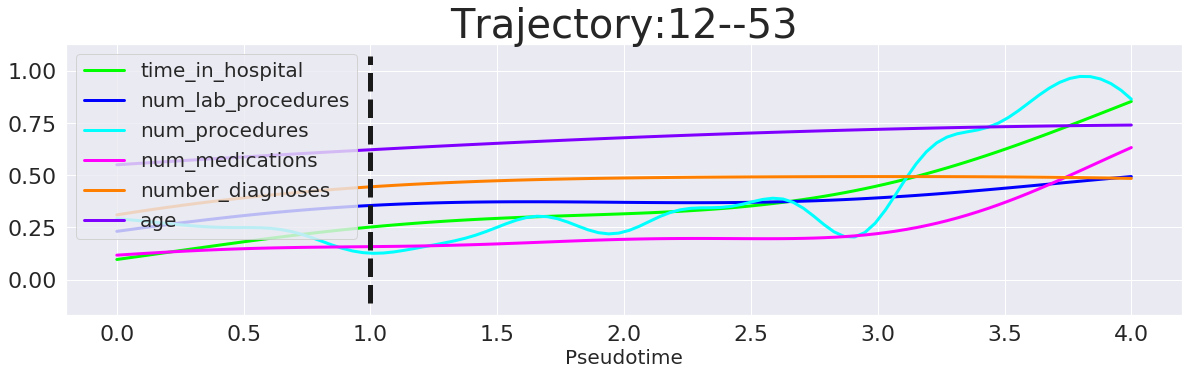

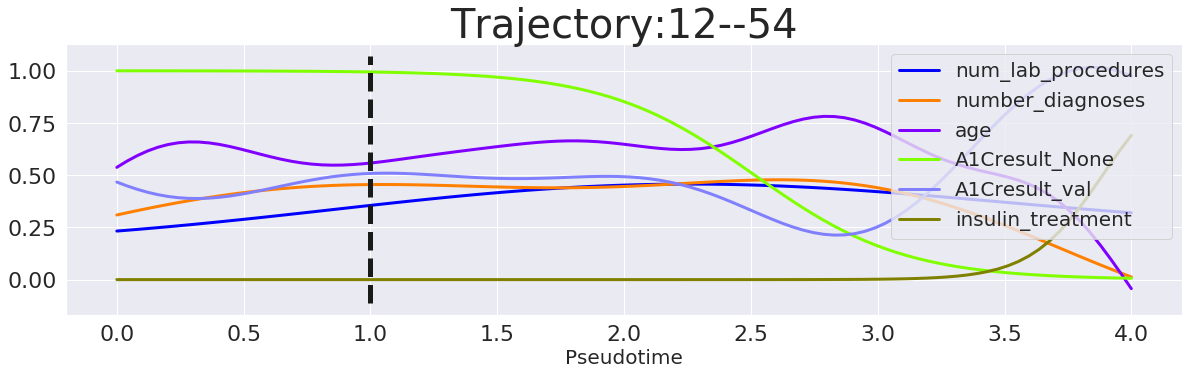

In [415]:
# Draw pseudotime dependencies of variables significantly associated with trajectories

reload(clintraj_util)
from clintraj_util import get_standard_color_seq


color_seq = get_standard_color_seq()
var_colors = {}
all_vars = list(all_trajectory_variable_associations.keys())
complication_variables = ['readmitted']
k=0
for var in complication_variables:
    if var in all_trajectory_variable_associations:
        #print(k)
        var_colors[var] = color_seq[k]
        k = k+1
        if k>len(color_seq)-1:
            k=0
for var in all_vars:
    if not var in complication_variables:
        #print(k)
        var_colors[var] = color_seq[k]
        k = k+1
        if k>len(color_seq)-1:
            k=0

sns.set(font_scale=2)

min_val = 1
max_val = 0

for pstt in PseudoTimeTraj:
    TrajName = 'Trajectory:'+str(pstt['Trajectory'][0])+'--'+str(pstt['Trajectory'][-1])
    fig = plt.figure(figsize=(20, 5))
    for var in all_trajectory_variable_associations:
        associations = all_trajectory_variable_associations[var]
        for assoc in associations:
            trajn = assoc[0]
            if trajn==TrajName:
                var = assoc[1]
                if var in complication_variables:
                    vals = draw_pseudotime_dependence(pstt,var,variable_names,variable_types,X_original,var_colors[var],
                                               linewidth=6,draw_datapoints=False)
                else:
                    vals = draw_pseudotime_dependence(pstt,var,variable_names,variable_types,X_original,var_colors[var],
                                               linewidth=3,draw_datapoints=False)
                if vals is not None:
                    min_val = min(min_val,min(vals))
                    max_val = max(max_val,max(vals))
                #else:
                #    print(var,TrajName,' regressor is not found')
    bp = pstt['BranchingPoints']
    for x in bp:
        plt.plot([x,x],[min_val,max_val],'k--',linewidth=5)
    if TrajName.endswith('52'):
        plt.legend(fontsize=18,loc='upper left')
    else:
        plt.legend(fontsize=20)
    plt.title(TrajName,fontsize=40)
    plt.savefig(dataset_name+'_'+TrajName+'.png', format='png', dpi=300)
    plt.show()

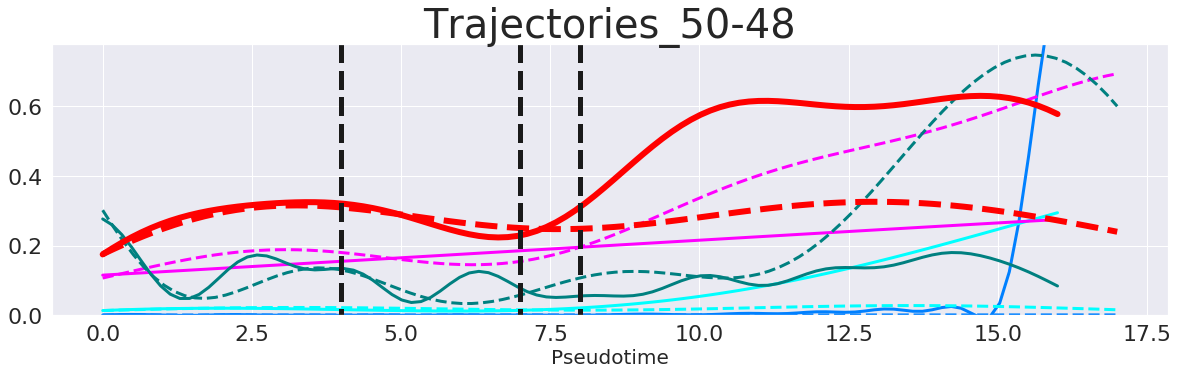

In [437]:
## Show selected variable dynamics on several trajectories simultaneously

reload(clintraj_eltree)
from clintraj_eltree import draw_pseudotime_dependence


color_seq = get_standard_color_seq()
var_colors = {}
line_styles = ['-','--','-.',':']

trajs_endpoints = [50,48]
trajs_endpoints_str = [str(ep) for ep in trajs_endpoints]
trajs = len(trajs_endpoints)*[None]
for pstt in PseudoTimeTraj:
    traj = pstt['Trajectory']
    if traj[-1] in trajs_endpoints:
        trajs[trajs_endpoints.index(traj[-1])] = pstt


#all_vars = ['number_emergency','time_in_hospital','A1Cresult_None','A1Cresult_val','diabetesMed_Yes','change_Ch','readmitted']
#all_vars = ['number_emergency','insulin_treatment','time_in_hospital','A1Cresult_None','A1Cresult_val','diabetesMed_Yes','change_Ch','readmitted']
all_vars = ['number_emergency','number_inpatient','time_in_hospital','num_procedures','readmitted']
#all_vars = ['insulin_treatment','A1Cresult_None','A1Cresult_val','diabetesMed_Yes']
if False:
    all_vars = []
    for var in all_trajectory_variable_associations:
        associations = all_trajectory_variable_associations[var]
        for assoc in associations:
            trajn = assoc[0]
            if trajn[-2:] in trajs_endpoints_str:
                all_vars.append(var)
    all_vars = list(set(all_vars))

for k,var in enumerate(all_vars):
    var_colors[var] = color_seq[k]

var_colors[all_vars[0]] = [0,0.5,1]
var_colors[all_vars[1]] = [0,1,1]
var_colors[all_vars[2]] = [1,0,1]
var_colors[all_vars[3]] = [0,0.5,0.5]
var_colors[all_vars[4]] = [1,0,0]

#var_colors[all_vars[0]] = [1,1,0]
#var_colors[all_vars[1]] = [0.5,0.5,0]
#var_colors[all_vars[2]] = [0,1,0]
#var_colors[all_vars[3]] = [0,0,1]
    
title = 'Trajectories_'+'-'.join(trajs_endpoints_str)
fig = plt.figure(figsize=(20, 5))
bp = []
for var in all_vars:
    for p,pstt in enumerate(trajs):
        if var in complication_variables:
            vals = draw_pseudotime_dependence(pstt,var,variable_names,variable_types,X_original,var_colors[var],
                                       linewidth=6,draw_datapoints=False,label=var+'_'+trajs_endpoints_str[p],
                                       linestyle=line_styles[p])
        else:
            vals = draw_pseudotime_dependence(pstt,var,variable_names,variable_types,X_original,var_colors[var],
                                       linewidth=3,draw_datapoints=False,label=var+'_'+trajs_endpoints_str[p],
                                       linestyle=line_styles[p])
            #plt.legend(fontsize=20)
            #plt.ylim([0,1])
        if vals is not None:
            min_val = min(min_val,min(vals))
            max_val = max(max_val,max(vals))
        bp1 = pstt['BranchingPoints']
        bp = bp+bp1
    for x in bp:
        plt.plot([x,x],[min_val,max_val],'k--',linewidth=5)
    #plt.legend(fontsize=10)
    plt.title(title,fontsize=40)
    plt.savefig(dataset_name+'_'+title+'.png', format='png', dpi=300)
    
    #plt.ylim([0,1.05])
    plt.ylim([0,0.78])
    plt.savefig(dataset_name+'_bifurcation_example.png', format='png', dpi=300)
plt.show()
    

['num_lab_procedures', 'A1Cresult_None', 'number_diagnoses', 'time_in_hospital', 'num_procedures', 'num_medications', 'readmitted', 'number_emergency', 'number_inpatient', 'A1Cresult_val', 'change_Ch', 'metformin_treatment', 'glyburide_treatment', 'insulin_treatment', 'age', 'diabetesMed_Yes']



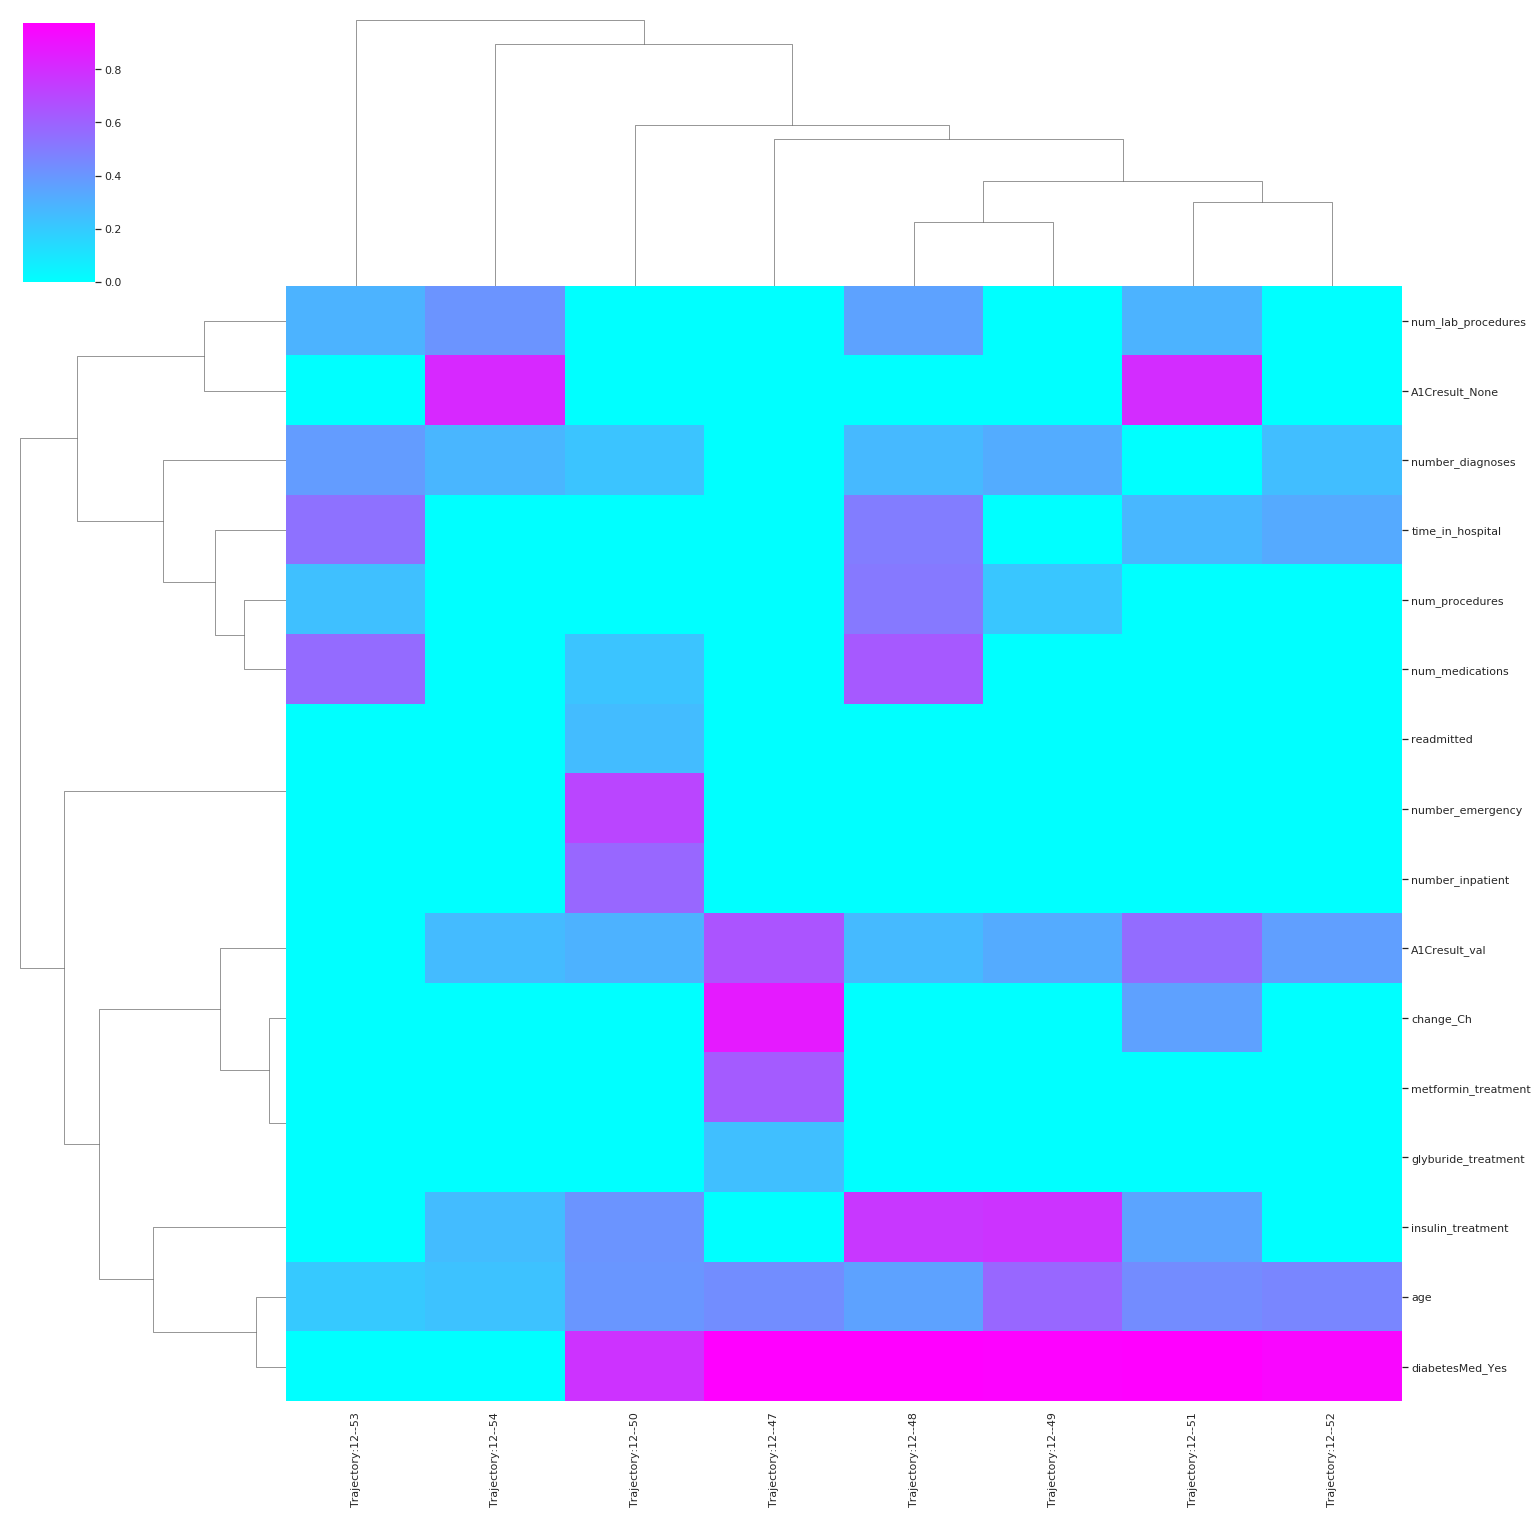

In [438]:
# Visualize associations between variables and trajectories

matrix_of_scores,keys,objects = get_matrix_of_association_scores(all_trajectory_variable_associations)

sns.set(color_codes=True)
#g = sns.clustermap(matrix_of_scores,metric="correlation",figsize=(7, 20))
g = sns.clustermap(matrix_of_scores,metric="correlation",figsize=(20, 20),cmap='cool')
objects_reordered = [objects[ind] for ind in g.dendrogram_col.reordered_ind]
keys_reordered = [keys[ind] for ind in g.dendrogram_row.reordered_ind]
g.ax_heatmap.set_xticklabels(objects_reordered)
g.ax_heatmap.set_yticklabels(keys_reordered)
print(keys_reordered)
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)
plt.savefig(dataset_name+'_associations_trajectories.png', format='png', dpi=300)
print()


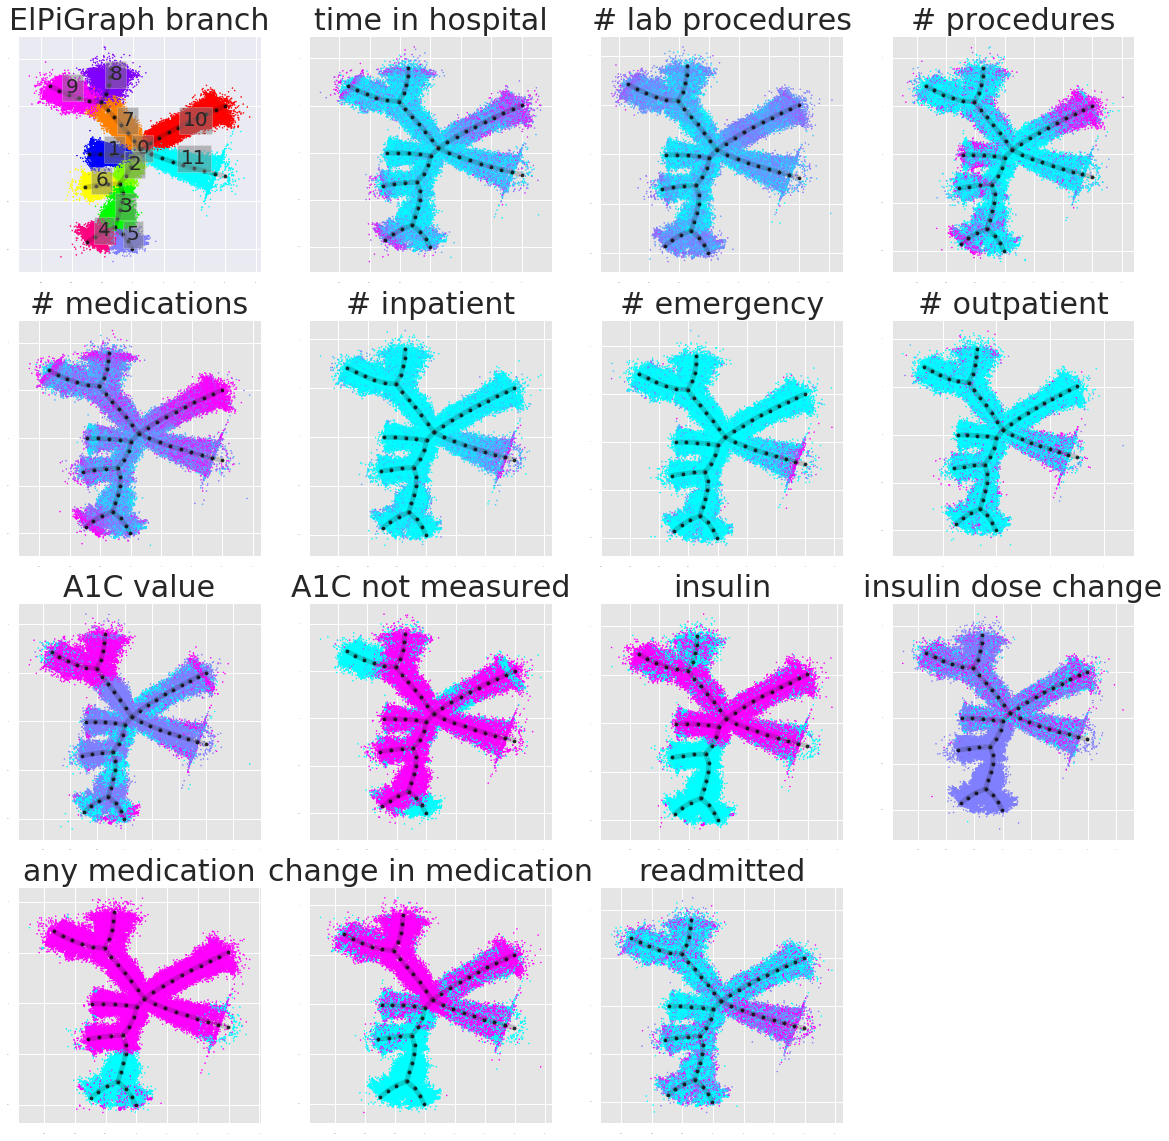

In [319]:
reload(clintraj_eltree)
from clintraj_eltree import visualize_eltree_with_data,pseudo_time_trajectory,extract_trajectories,quantify_pseudotime

# visualizing some of the results on top of the tree

n_subplots_x, n_subplots_y = 4, 4
plt.style.use('ggplot')
fig = plt.figure(figsize=(20, 20))
title_font_size = 30
scatter_parameter = 0.1

cmap = 'cool'
point_size = 1
Max_Edge_Width = 5

showAll = True

sns.set(font_scale=0,palette='bright')

# Visualize partionining of data by branches
i=1
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,
                          showBranchNumbers=True,Color_by_partitioning=True,Normal_Point_Size=point_size,
                           visualize_partition=vec_labels_by_branches,scatter_parameter=scatter_parameter)
plt.title('ElPiGraph branch',fontsize=title_font_size)

# Show only points of classes strongly associated with branches
#i=i+1
#list_of_node_class_associations,p,stat = associate_with_categorical_var(vec_labels_by_branches,'CLASS',color,'CATEGORICAL',
#                                                            score_threshold=0.7,
#                                                            Negative_Enrichment=False,
#                                                            Minimal_number_of_points=5,verbose=False)
#ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
#plt.title('Classes associated\nwith branches',fontsize=title_font_size)
#visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,
#                          Visualize_Branch_Class_Associations=list_of_node_class_associations,
#                          scatter_parameter=scatter_parameter)


# time_in_hospital
i=i+1
feature='time_in_hospital'
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.title('time in hospital',fontsize=title_font_size)
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,
                          Invert_Edge_Value=True,Max_Edge_Width=Max_Edge_Width,Color_by_feature=feature, 
                           Feature_Edge_Width=feature,cmap=cmap,Normal_Point_Size=point_size,
                          scatter_parameter=scatter_parameter)

#num_lab_procedures
if showAll:
    i=i+1
    feature='num_lab_procedures'
    ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
    plt.title('# lab procedures',fontsize=title_font_size)
    visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,
                              Invert_Edge_Value=True,Max_Edge_Width=Max_Edge_Width,Color_by_feature=feature, 
                               Feature_Edge_Width=feature,cmap=cmap,Normal_Point_Size=point_size,
                              scatter_parameter=scatter_parameter)

#num_procedures
i=i+1
feature='num_procedures'
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.title('# procedures',fontsize=title_font_size)
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,
                          Invert_Edge_Value=True,Max_Edge_Width=Max_Edge_Width,Color_by_feature=feature, 
                           Feature_Edge_Width=feature,cmap=cmap,Normal_Point_Size=point_size,
                          scatter_parameter=scatter_parameter)

#num_medications
if showAll:
    i=i+1
    feature='num_medications'
    ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
    plt.title('# medications',fontsize=title_font_size)
    visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,
                              Invert_Edge_Value=True,Max_Edge_Width=Max_Edge_Width,Color_by_feature=feature, 
                               Feature_Edge_Width=feature,cmap=cmap,Normal_Point_Size=point_size,
                              scatter_parameter=scatter_parameter,vmax=30)


i=i+1
feature='number_inpatient'
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.title('# inpatient',fontsize=title_font_size)
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,
                          Invert_Edge_Value=True,Max_Edge_Width=Max_Edge_Width,Color_by_feature=feature, 
                           Feature_Edge_Width=feature,cmap=cmap,Normal_Point_Size=point_size,
                          scatter_parameter=scatter_parameter,vmax=10)

i=i+1
feature='number_emergency'
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.title('# emergency',fontsize=title_font_size)
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,
                          Invert_Edge_Value=True,Max_Edge_Width=Max_Edge_Width,Color_by_feature=feature, 
                           Feature_Edge_Width=feature,cmap=cmap,Normal_Point_Size=point_size,
                          scatter_parameter=scatter_parameter,vmax=5)


if showAll:
    i=i+1
    feature='number_outpatient'
    ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
    plt.title('# outpatient',fontsize=title_font_size)
    visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,
                              Invert_Edge_Value=True,Max_Edge_Width=Max_Edge_Width,Color_by_feature=feature, 
                               Feature_Edge_Width=feature,cmap=cmap,Normal_Point_Size=point_size,
                              scatter_parameter=scatter_parameter,vmax=5)


#i=i+1
#feature='age'
#ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
#plt.title('age',fontsize=title_font_size)
#visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,
#                          Invert_Edge_Value=True,Max_Edge_Width=20,Color_by_feature=feature, 
#                           Feature_Edge_Width=feature,cmap=cmap,Normal_Point_Size=point_size,
#                          scatter_parameter=scatter_parameter)

i=i+1
feature='A1Cresult_val'
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.title('A1C value',fontsize=title_font_size)
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,
                          Invert_Edge_Value=True,Max_Edge_Width=Max_Edge_Width,Color_by_feature=feature, 
                           Feature_Edge_Width=feature,cmap=cmap,Normal_Point_Size=point_size,
                          scatter_parameter=scatter_parameter)

if True:
    i=i+1
    feature='A1Cresult_None'
    ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
    plt.title('A1C not measured',fontsize=title_font_size)
    visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,
                              Invert_Edge_Value=True,Max_Edge_Width=Max_Edge_Width,Color_by_feature=feature, 
                               Feature_Edge_Width=feature,cmap=cmap,Normal_Point_Size=point_size,
                              scatter_parameter=scatter_parameter)


i=i+1
feature='insulin_treatment'
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.title('insulin',fontsize=title_font_size)
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,
                          Invert_Edge_Value=True,Max_Edge_Width=Max_Edge_Width,Color_by_feature=feature, 
                           Feature_Edge_Width=feature,cmap=cmap,Normal_Point_Size=point_size,
                          scatter_parameter=scatter_parameter)


i=i+1
feature='insulin_treatment_change'
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.title('insulin dose change',fontsize=title_font_size)
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,
                          Invert_Edge_Value=True,Max_Edge_Width=Max_Edge_Width,Color_by_feature=feature, 
                           Feature_Edge_Width=feature,cmap=cmap,Normal_Point_Size=point_size,
                          scatter_parameter=scatter_parameter)


i=i+1
feature='diabetesMed_Yes'
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.title('any medication',fontsize=title_font_size)
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,
                          Invert_Edge_Value=True,Max_Edge_Width=Max_Edge_Width,Color_by_feature=feature, 
                           Feature_Edge_Width=feature,cmap=cmap,Normal_Point_Size=point_size,
                          scatter_parameter=scatter_parameter)

i=i+1
feature='change_Ch'
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.title('change in medication',fontsize=title_font_size)
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,
                          Invert_Edge_Value=True,Max_Edge_Width=Max_Edge_Width,Color_by_feature=feature, 
                           Feature_Edge_Width=feature,cmap=cmap,Normal_Point_Size=point_size,
                          scatter_parameter=scatter_parameter)

i=i+1
feature='readmitted'
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.title('readmitted',fontsize=title_font_size)
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,
                          Invert_Edge_Value=True,Max_Edge_Width=Max_Edge_Width,Color_by_feature=feature, 
                           Feature_Edge_Width=feature,cmap=cmap,Normal_Point_Size=point_size,
                          scatter_parameter=scatter_parameter)


plt.savefig(dataset_name+'_principal_tree_visexamples.png', format='png', dpi=400)
plt.show()

['No', 'Steady', 'Down', 'Up'] [[0, 0, 1], [1, 1, 0], [0, 1, 0], [1, 0, 0]]
['No', 'Steady', 'Up', 'Down'] [[0, 0, 1], [1, 1, 0], [1, 0, 0], [0, 1, 0]]
['No', 'Steady', 'Up', 'Down'] [[0, 0, 1], [1, 1, 0], [1, 0, 0], [0, 1, 0]]
['No', 'Steady', 'Up', 'Down'] [[0, 0, 1], [1, 1, 0], [1, 0, 0], [0, 1, 0]]


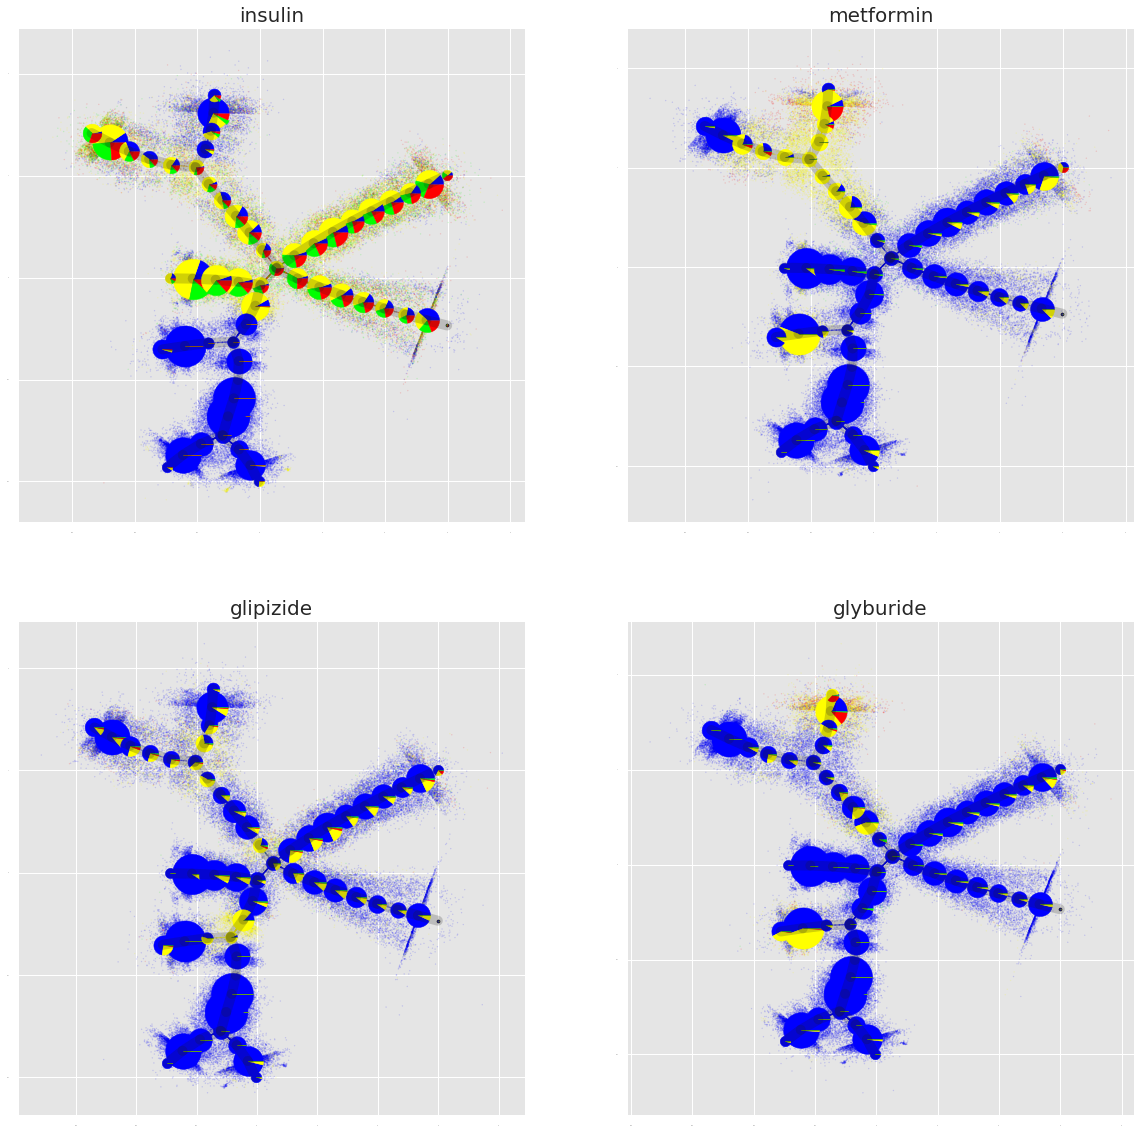

In [280]:
## visualize medication

reload(clintraj_eltree)
from clintraj_eltree import visualize_eltree_with_data,pseudo_time_trajectory,extract_trajectories,quantify_pseudotime
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

title_font_size=20
point_size=1

medications = ['insulin','metformin','glipizide','glyburide']

fig = plt.figure(figsize=(20,20))
for i,feature in enumerate(medications):
    ax = fig.add_subplot(2,2,i+1)
    plt.title(feature,fontsize=title_font_size)
    color_seq = [[0, 0, 1], [1, 1, 0], [1, 0, 0], [0, 1, 0]]
    color_annot, vals_unique, vals_freq = get_colorseq_for_column(annotation_data,feature,color_seq)
    color_seq[vals_unique.index('No')] = [0,0,1]
    color_seq[vals_unique.index('Steady')] = [1,1,0]
    color_seq[vals_unique.index('Up')] = [1,0,0]
    color_seq[vals_unique.index('Down')] = [0,1,0]
    color_annot, vals_unique, vals_freq = get_colorseq_for_column(annotation_data,feature,color_seq)
    visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color_annot,variable_names,
                              Min_Edge_Width=10,Max_Edge_Width=10,showNodeNumbers=False,
                               Color_by_feature='', Feature_Edge_Width='',Normal_Point_Size=point_size,
                              Visualize_Edge_Width_AsNodeCoordinates=True,scatter_parameter=0.1,percentile_contraction=20,
                              Transparency_Alpha_points=0.1)
    add_pie_charts(ax,tree_extended['NodePositions2D'],color_annot,color_seq,scale=0.3)
    print(vals_unique,color_seq)

plt.savefig(dataset_name+'_principal_tree_medications.png', format='png', dpi=400)
plt.show()


['Other', 'Circulatory', 'Respiratory', 'Digestive', 'Diabetis', 'Injury'] [30881 29681 13934  9333  8661  6853] [[1, 1, 1], [0, 1, 0], [0, 0, 1], [0, 0, 1], [1, 0, 0], [0, 0, 1]]
['Other', 'blue', 'Circulatory', 'Diabetis'] [30881 30120 29681  8661]


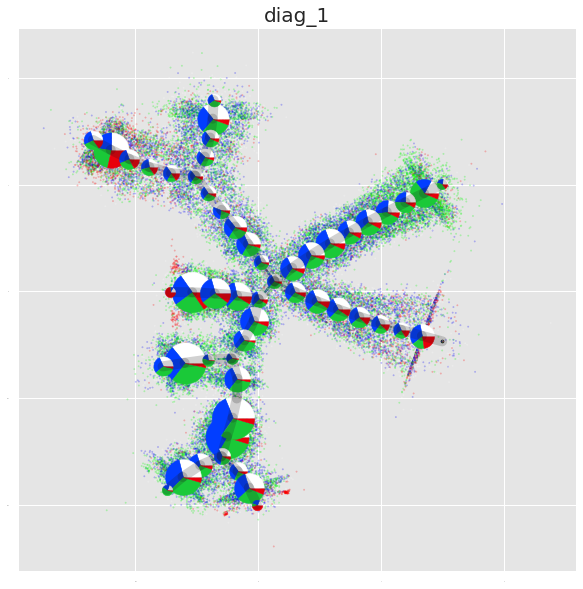

In [297]:
## visualize diagnosis

reload(clintraj_eltree)
from clintraj_eltree import visualize_eltree_with_data,pseudo_time_trajectory,extract_trajectories,quantify_pseudotime

title_font_size=20
point_size =2
feature = 'diag_1'

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
plt.title(feature,fontsize=title_font_size)
if feature=='diag_1':
    color_seq = [[1, 1, 1], [0, 1, 0], [0, 0, 1], [0, 0, 1], [1, 0, 0], [0, 0, 1]]
if feature=='diag_2':
    color_seq = [[1, 1, 1], [0, 1, 0], [1, 0, 0], [0, 0, 1], [0, 0, 1], [0, 0, 1]]
if feature=='diag_3':
    color_seq = [[1, 1, 1], [0, 1, 0], [1, 0, 0], [0, 0, 1], [0, 0, 1], [0, 0, 1]]

color_annot, vals_unique, vals_unique_freq = get_colorseq_for_column(annotation_data,feature,color_seq=color_seq)
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color_annot,variable_names,
                          Min_Edge_Width=10,Max_Edge_Width=10,showNodeNumbers=False,
                           Color_by_feature='', Feature_Edge_Width='',Normal_Point_Size=point_size,
                          Visualize_Edge_Width_AsNodeCoordinates=True,scatter_parameter=0.1,percentile_contraction=20,
                          Transparency_Alpha_points=0.2)

print(vals_unique,vals_unique_freq,color_seq)

#plt.scatter(tree_extended['NodePositions2D'][:,0],tree_extended['NodePositions2D'][:,1],s=400)

vals = list(annotation_data[feature].replace({'Respiratory':'blue','Digestive':'blue','Injury':'blue'}))
add_pie_charts(ax,tree_extended['NodePositions2D'],vals,['w','b','g','r'],scale=0.3)

plt.savefig(dataset_name+'_principal_tree_'+feature+'.png', format='png', dpi=400)
plt.show()

['Emergency', 'Elective', 'Urgent', 'Other', 'Trauma Center', '4'] [52371 18668 18132 10144    18    10] [[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 1, 1], [0, 0, 1], [0, 0, 1]]
['red', 'green', 'blue', 'white'] [52371 18668 18132 10172]


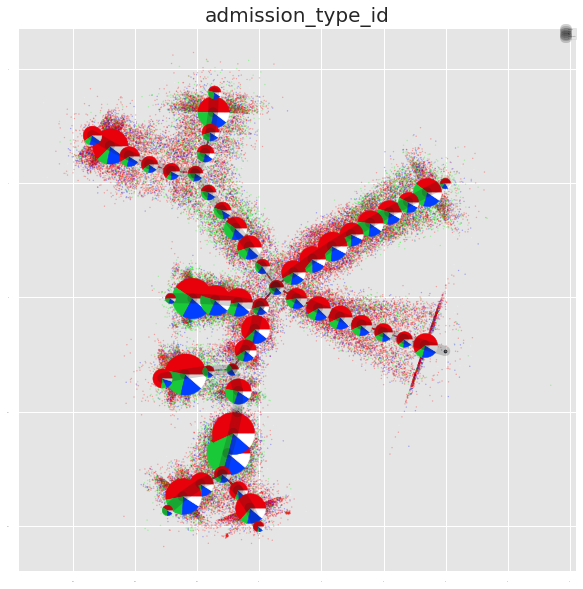

In [301]:

point_size =1

feature = 'admission_type_id'

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
plt.title(feature,fontsize=title_font_size)
color_seq = [[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 1, 1], [0, 0, 1],[0,0,1]]

color_annot, vals_unique, vals_unique_freq = get_colorseq_for_column(annotation_data,feature,color_seq=color_seq)
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color_annot,variable_names,
                          Min_Edge_Width=10,Max_Edge_Width=10,showNodeNumbers=False,
                           Color_by_feature='', Feature_Edge_Width='',Normal_Point_Size=point_size,
                          Visualize_Edge_Width_AsNodeCoordinates=True,scatter_parameter=0.1,percentile_contraction=20,
                          Transparency_Alpha_points=0.2)
print(vals_unique,vals_unique_freq,color_seq)
vals = list(annotation_data[feature].replace({'Emergency':'red','Elective':'green','Other':'white','Urgent':'blue','Trauma Center':'white','4':'white'}))
add_pie_charts(ax,tree_extended['NodePositions2D'],vals,['r','g','b','w'],scale=0.3)
plt.legend(vals_unique)
plt.savefig(dataset_name+'_principal_tree_'+feature+'.png', format='png', dpi=400)
plt.show()


6
Start computations...
PCA: 1.9e-06 sec
t-SNE: 3.3e-06 sec
UMAP: 2.4e-06 sec
TRIMAP: 2.4e-06 sec


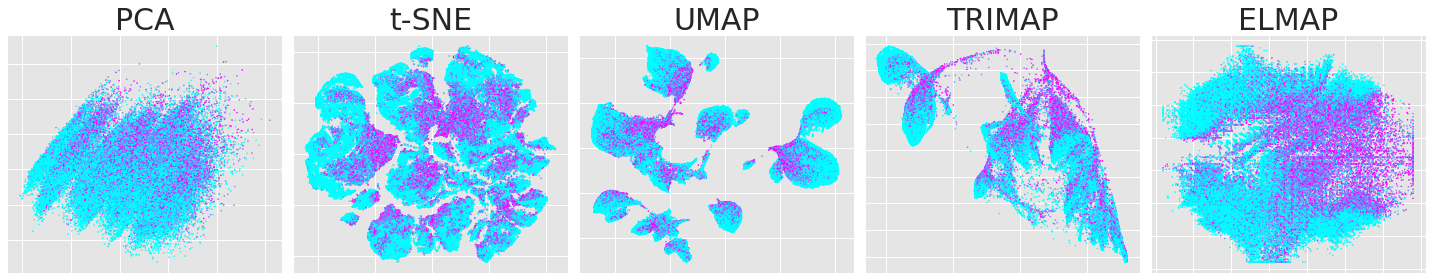

In [137]:
# Here the manifold learning is computed and saved in viz_results

print(X.shape[1])

sns.set(palette='bright')

methods_to_apply=['PCA','TRIMAP','UMAP','TSNE','ELMAP']
n_subplots_x=1
n_subplots_y=5
figsizex = 20
figsizey = 4

viz_results = apply_panel_of_manifold_learning_methods(X,color,
    Color_by_branches=[],precomputed_results=viz_results,color_map='cool',ColorByFeature='', variable_names=[],
    ElMapFolder=ElMapFolder,methods_to_apply=methods_to_apply,points_size=1,
                                                      n_subplots_x=n_subplots_x,n_subplots_y=n_subplots_y,
                                                      figsizex=figsizex,figsizey=figsizey)
plt.savefig(dataset_name+'_manifolds_color_by_class.png', format='png', dpi=300)
plt.show()

Start computations...
PCA: 0.00031 sec
t-SNE: 0.0001 sec
UMAP: 0.00011 sec
TRIMAP: 0.00024 sec


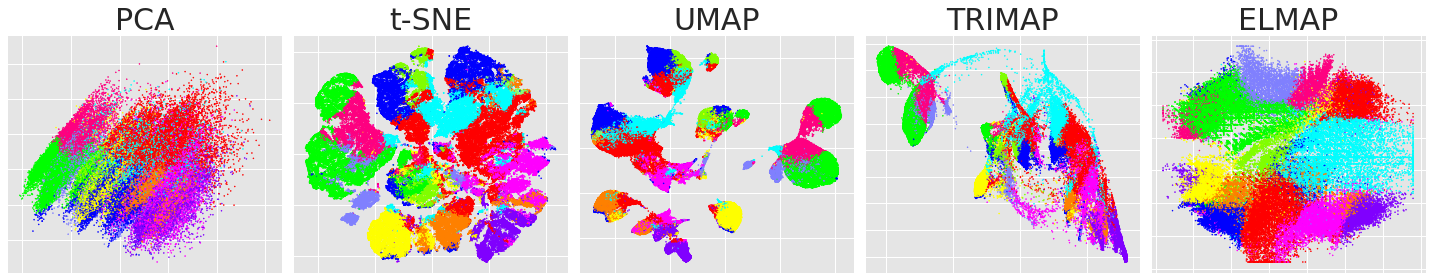

In [135]:
# Now we color by branches of the principal tree
# Here we use the results of the previous computations by specifying 'precomputed_results'

apply_panel_of_manifold_learning_methods(X,color,
    Color_by_branches=vec_labels_by_branches,precomputed_results=viz_results,color_map='cool',ColorByFeature='', 
    variable_names=[],
    ElMapFolder=ElMapFolder,methods_to_apply=methods_to_apply,n_subplots_x=n_subplots_x,n_subplots_y=n_subplots_y,
                                         figsizex=figsizex,figsizey=figsizey,points_size=1)
plt.savefig(dataset_name+'_manifolds_color_by_tree_branch.png', format='png', dpi=300)
plt.show()

Start computations...
PCA: 1.7e-06 sec
t-SNE: 1.9e-06 sec
UMAP: 3.8e-06 sec
TRIMAP: 2.1e-06 sec


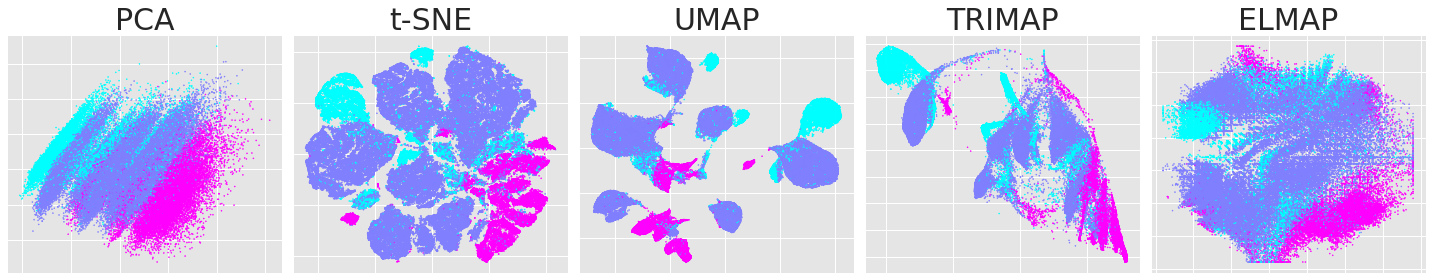

In [136]:
# Now we color by some features of the data
# Here we use the results of the previous computations by specifying 'precomputed_results'

#feature = 'number_inpatient'
#feature = 'time_in_hospital'
feature = 'A1Cresult_val'
#feature = 'A1Cresult_None'
#feature = 'readmitted'
#feature = 'number_outpatient'
#feature = 'age'
#feature = 'insulin_treatment'
#feature = 'insulin_treatment_change'
#feature = 'diabetesMed_Yes'
#feature = 'change_Ch'
#feature = 'metformin_treatment'
#feature = 'number_diagnoses'
#feature = 'number_emergency'
#feature = 'number_emergency'
#feature = 'readmitted'

apply_panel_of_manifold_learning_methods(X_original,color,
    Color_by_branches=vec_labels_by_branches,precomputed_results=viz_results,color_map='cool',
    ColorByFeature=feature, variable_names=variable_names,
    ElMapFolder=ElMapFolder,methods_to_apply=methods_to_apply,
    n_subplots_x=1,n_subplots_y=5,
    figsizex=figsizex,figsizey=figsizey,points_size=1)
plt.savefig(dataset_name+'_manifolds_color_by_'+feature+'.png', format='png', dpi=300)
plt.show()